PRT 565 Assignment2
Name:Bornali Rahman
ID:s372226

Data Analysis for estimation of obesity level
The purpose of this analysis is to develop a ML based model on the dataset of obesity , to estimate the obesity levels. This data set is based on eating habits and physical condition in individuals from Colombia, Peru and Mexico.

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Environment Setup and Data Load
Before starting the analysis the enciroment should set up properly by importing the necessary library.

In [55]:
from datetime import datetime
import warnings; warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [56]:
raw_path ="/content/drive/MyDrive/ML_As_2/ObesityDataSet_raw_and_data_sinthetic.csv"
clean_path = "/content/drive/MyDrive/ML_As_2/obesity_cleaned.csv"
SAVE_PNG   = False

#Data load
#Dataset Analysis
#Data Pre-processing

In [57]:
df = pd.read_csv(raw_path)

print("Null Data:\n", df.isnull().sum())
print("Data Shape:\n", df.shape)
print("Data Top 10 Rows: \n", df.head(10))


Null Data:
 Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
Data Shape:
 (2111, 17)
Data Top 10 Rows: 
    Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  

In [58]:
print("Data Type:\n", df.dtypes)
print("Data duplicate:\n", df.duplicated().sum())


Data Type:
 Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object
Data duplicate:
 24


Variable Name
Demographic	Variables
1.Gender
2.Age


Independent variables
Height
Weight
family_history_with_overweight:Has a family member suffered or suffers from overweight?
FAVC :Do you eat high caloric food frequently?
FCVC:Do you usually eat vegetables in your meals?
NCP:How many main meals do you have daily?
CAEC : Do you eat any food between meals?
SMOKE :Do you smoke?
CH20 :How much water do you drink daily?
SCC :Do you monitor the calories you eat daily?
FAF:How often do you have physical activity?
TUE :How much time do you use technological devices (cellphone, videogames, TV)?
CALC:How often do you drink alcohol?
MTRANS :Which transportation do you usually use?

Target Variables
NObeyesdad : Obesity level


Data Preparation

Data Standardization

In [59]:
# Standardize column names and fix CH20 -> CH2O if present
df.columns = [c.strip() for c in df.columns]
if "CH20" in df.columns and "CH2O" not in df.columns:
    df = df.rename(columns={"CH20": "CH2O"})

Feature encoding

In [60]:
# ---------- SCHEMA (from your table) ----------
categorical_cols = [
    "Gender","family_history_with_overweight","FAVC","CAEC","SMOKE",
    "SCC","CALC","MTRANS","NObeyesdad"   # target
]
# These are often listed as Integer in some tables but can have decimals in files.
# We'll try integer, fall back to float automatically.
integer_cols    = ["FCVC","TUE"]
continuous_cols = ["Age","Height","Weight","NCP","CH2O","FAF"]  # BMI added below

In [61]:
# Safe numeric conversion: keeps float if decimals exist
def safe_to_int_or_float(s: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(s, errors="coerce")
    s_nz  = s_num.dropna()
    # If all non-missing are whole numbers, keep integer; else float
    if len(s_nz) and np.all(np.isclose(s_nz, np.round(s_nz))):
        return s_num.round().astype("Int64")
    return s_num  # leave as float

# Apply dtype intentions
for c in integer_cols:
    if c in df.columns:
        df[c] = safe_to_int_or_float(df[c])

for c in continuous_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

for c in categorical_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

In [62]:
# Simple cleaning: drop exact duplicates
dfc = df.drop_duplicates()

print("Data Shape Before:\n", df.shape)
print("Data Shape After:\n", dfc.shape)

Data Shape Before:
 (2111, 17)
Data Shape After:
 (2087, 17)


Feature Engineering

In [63]:
#  BMI
if {"Height","Weight"}.issubset(dfc.columns) and "BMI" not in dfc.columns:
    dfc["BMI"] = pd.to_numeric(dfc["Weight"], errors="coerce") / (pd.to_numeric(dfc["Height"], errors="coerce")**2)

In [64]:
cols_to_drop = [c for c in ["Height", "Weight"] if c in dfc.columns]
dfc = dfc.drop(columns=cols_to_drop)
print("Dropped columns:", cols_to_drop)

Dropped columns: ['Height', 'Weight']


Now BMI is new column for the analysis created from Height and Weight.Now, dropped Height and Weight Column

Save clean dataset

In [65]:
# Impute only for EDA views (median for numeric, mode for categorical)
num_cols = dfc.select_dtypes(include=["number","Int64"]).columns.tolist()
cat_cols = dfc.select_dtypes(include=["category","object"]).columns.tolist()
for c in num_cols:
    if dfc[c].isna().any():
        dfc[c] = dfc[c].fillna(dfc[c].median())
for c in cat_cols:
    if dfc[c].isna().any():
        dfc[c] = dfc[c].fillna(dfc[c].mode().iloc[0])

# Save cleaned copy for modeling later
dfc.to_csv(clean_path, index=False)
print("\nSaved cleaned CSV ->", clean_path)


Saved cleaned CSV -> /content/drive/MyDrive/ML_As_2/obesity_cleaned.csv


Exploratory Data Analysis (EDA)

In [66]:
# ---------- Basic stats ----------
print("\nNumeric summary:")
display(dfc[num_cols].describe().T)

print("\nTop counts for categorical variables:")
for c in cat_cols:
    vc = dfc[c].value_counts(dropna=False)
    display(pd.DataFrame({"count": vc, "percent": (vc/len(dfc)*100).round(2)}).head(20))


Numeric summary:


count       mean       std        min        25%        50%        75%  \
Age   2087.0  24.353090  6.368801  14.000000  19.915937  22.847618  26.000000   
FCVC  2087.0   2.421466  0.534737   1.000000   2.000000   2.396265   3.000000   
NCP   2087.0   2.701179  0.764614   1.000000   2.697467   3.000000   3.000000   
CH2O  2087.0   2.004749  0.608284   1.000000   1.590922   2.000000   2.466193   
FAF   2087.0   1.012812  0.853475   0.000000   0.124505   1.000000   1.678102   
TUE   2087.0   0.663035  0.608153   0.000000   0.000000   0.630866   1.000000   
BMI   2087.0  29.765758  8.024934  12.998685  24.368897  28.896224  36.095538   

            max  
Age   61.000000  
FCVC   3.000000  
NCP    4.000000  
CH2O   3.000000  
FAF    3.000000  
TUE    2.000000  
BMI   50.811753


Top counts for categorical variables:


count  percent
Gender                
Male     1052    50.41
Female   1035    49.59

count  percent
family_history_with_overweight                
yes                              1722    82.51
no                                365    17.49

count  percent
FAVC                
yes    1844    88.36
no      243    11.64

count  percent
CAEC                      
Sometimes    1761    84.38
Frequently    236    11.31
Always         53     2.54
no             37     1.77

count  percent
SMOKE                
no      2043    97.89
yes       44     2.11

count  percent
SCC                
no    1991     95.4
yes     96      4.6

count  percent
CALC                      
Sometimes    1380    66.12
no            636    30.47
Frequently     70     3.35
Always          1     0.05

count  percent
MTRANS                               
Public_Transportation   1558    74.65
Automobile               456    21.85
Walking                   55     2.64
Motorbike                 11     0.53
Bike                       7     0.34

count  percent
NObeyesdad                         
Obesity_Type_I         351    16.82
Obesity_Type_III       324    15.52
Obesity_Type_II        297    14.23
Overweight_Level_II    290    13.90
Normal_Weight          282    13.51
Overweight_Level_I     276    13.22
Insufficient_Weight    267    12.79

#Univariate Data Analysis

Demographic Variables - Age & Gender

In [67]:
#Demographic Variables

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use your cleaned frame if available; else fall back to df
if "dfc" in globals():
    data = dfc.copy()
else:
    data = df.copy()  # assumes df already loaded

# --- Age groups (bins + labels) ---
age = pd.to_numeric(data["Age"], errors="coerce")
bins   = [0, 13, 18, 25, 35, 45, 60,100]
labels = ["<13", "13-17", "18-24", "25-34", "35-44", "45-59", "60+"]

data["AgeGroup"] = pd.cut(age, bins=bins, labels=labels, right=False)

# Counts in the desired label order (even if some bins are empty)
counts = data["AgeGroup"].value_counts().reindex(labels, fill_value=0)

# --- Explode, colors, wedge style ---
# manual explode (same length as labels)
explode = (0.80, 0.10, 0.00, 0.00, 0.30, 0.30, 0.30)

colors  = ("orange", "cyan", "brown", "grey", "indigo", "brown", "orange")
wp      = {"linewidth": 1}

# % + count on the slices
def autopct_pct_count(pct):
    n = int(round(pct/100.0 * counts.sum()))
    return f"{pct:.1f}%\n({n})"

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(
    counts.values,
    explode=explode,
    colors=colors,
    startangle=90,
    counterclock=False,
    autopct=autopct_pct_count,
    wedgeprops=wp,
    textprops=dict(color="black")
)

ax.axis("equal")  # perfect circle
ax.set_title("Age Group Distribution")
ax.legend(wedges, counts.index, title="Age groups",
          loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


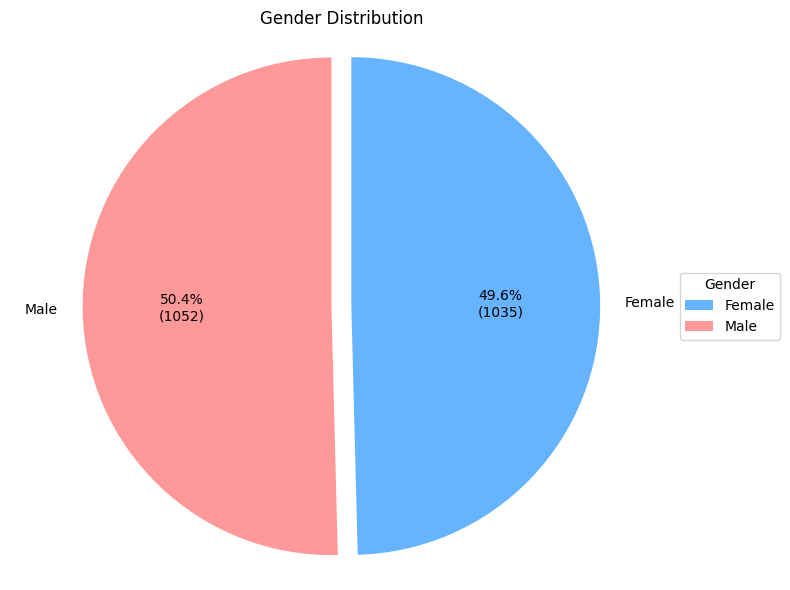

In [68]:
#Gender
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# use dfc if you created it; otherwise fall back to df
data = dfc.copy() if "dfc" in globals() else df.copy()

# Clean/standardise Gender values
s = data["Gender"].astype(str).str.strip().str.title()   # e.g., 'Male', 'Female'

# Desired order for legend/labels (falls back to observed order if different)
gender_order = ["Female", "Male"] if {"Female","Male"}.issubset(set(s.unique())) \
               else list(s.value_counts().index)

# Counts in that order
counts = s.value_counts().reindex(gender_order, fill_value=0)

# Style: explode the biggest slice a bit
explode = [0.08 if i == np.argmax(counts.values) else 0.0 for i in range(len(counts))]
colors  = ["#66b3ff", "#ff9999"][:len(counts)]          # 2 colors
wp      = {"linewidth": 1}

def autopct_pct_count(pct):
    n = int(round(pct/100.0 * counts.sum()))
    return f"{pct:.1f}%\n({n})"

fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    counts.values,
    labels=counts.index,
    explode=explode,
    colors=colors,
    startangle=90,
    counterclock=False,
    autopct=autopct_pct_count,
    wedgeprops=wp,
    textprops={"color": "black"}
)

ax.axis("equal")
ax.set_title("Gender Distribution")
ax.legend(wedges, counts.index, title="Gender", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


Other Variables:

Pie chart of Catagorical Variables

In [69]:
exclude_set = {"nobeyesdad", "age", "gender"}
cat_cols = [c for c in cat_cols if c.lower() not in exclude_set]

print("Plotting pies for:", cat_cols)

Plotting pies for: ['family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


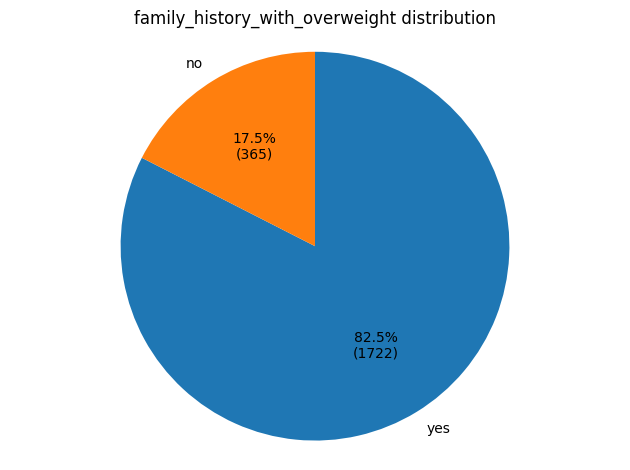

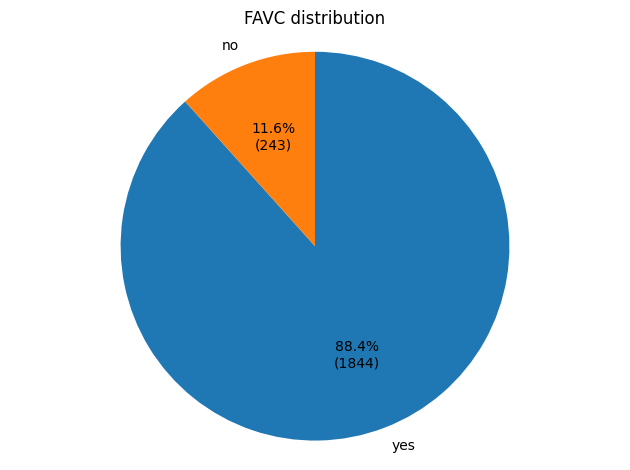

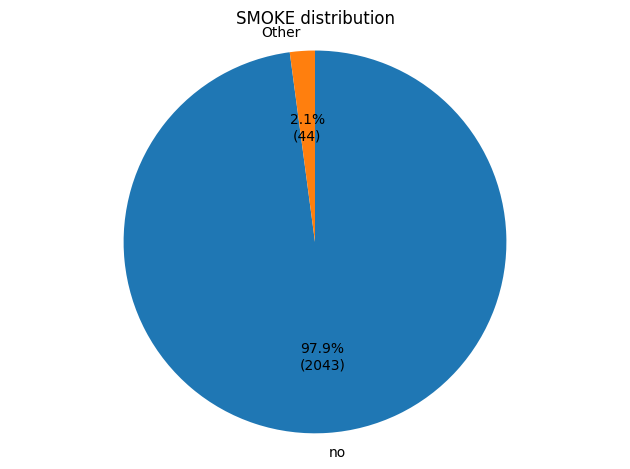

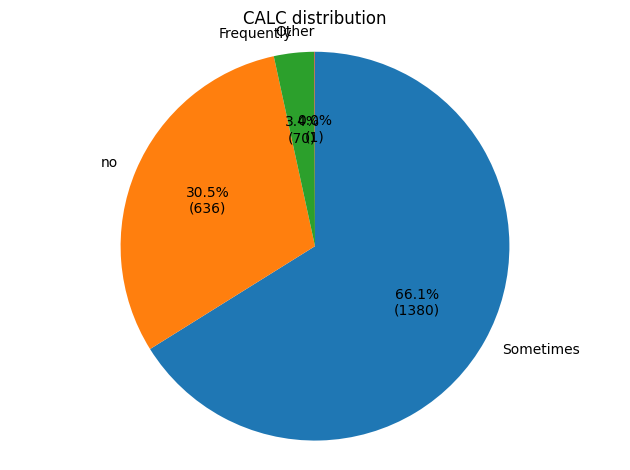

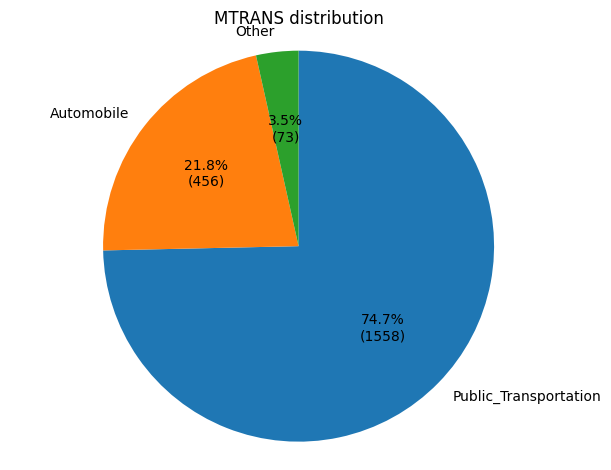

In [70]:
def plot_pie_for(series: pd.Series, title: str, min_pct=0.03, top_n=10, save=False):
    """
    Pie chart with % + counts.
    - Groups tiny slices (<min_pct) into 'Other'
    - Keeps only top_n categories, groups the rest into 'Other'
    """
    s = series.astype("string").fillna("Missing").str.strip()
    counts = s.value_counts(dropna=False)
    total = counts.sum()

    # Keep only top_n categories if many
    if top_n is not None and len(counts) > top_n:
        big = counts.head(top_n)
        other = counts.iloc[top_n:].sum()
        counts = pd.concat([big, pd.Series({"Other": other})])

    # Group very small categories
    pct = counts / total
    small = pct < min_pct
    if small.any():
        big_counts = counts[~small]
        other_sum = counts[small].sum()
        counts = pd.concat([big_counts, pd.Series({"Other": other_sum})])

    def _autopct(p):
        n = int(round(p * total / 100.0))
        return f"{p:.1f}%\n({n})"

    plt.figure()
    plt.pie(counts.values, labels=counts.index, autopct=_autopct, startangle=90, counterclock=False)
    plt.title(title)
    plt.axis("equal")
    plt.tight_layout()
    if save:
        fn = f"pie_{title.replace(' ','_')}.png"
        plt.savefig(fn, dpi=150, bbox_inches="tight")
        print("Saved:", fn)
    plt.show()

# Make pies
for col in cat_cols:
    plot_pie_for(data[col], title=f"{col} distribution", min_pct=0.03, top_n=10, save=False)

Histogram of numeric variables

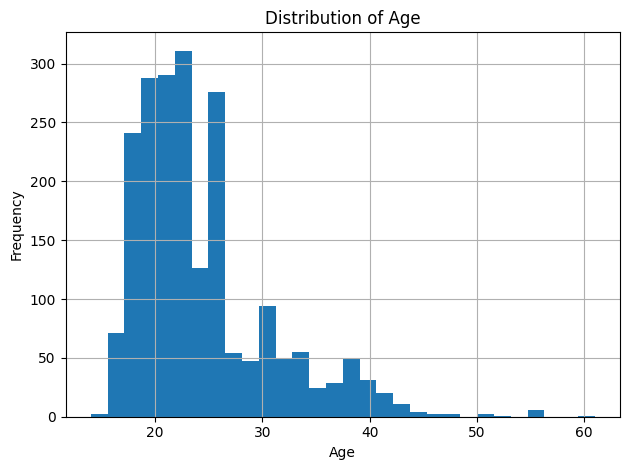

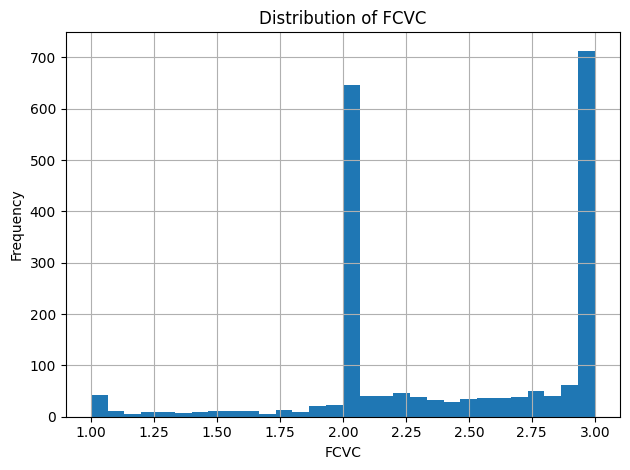

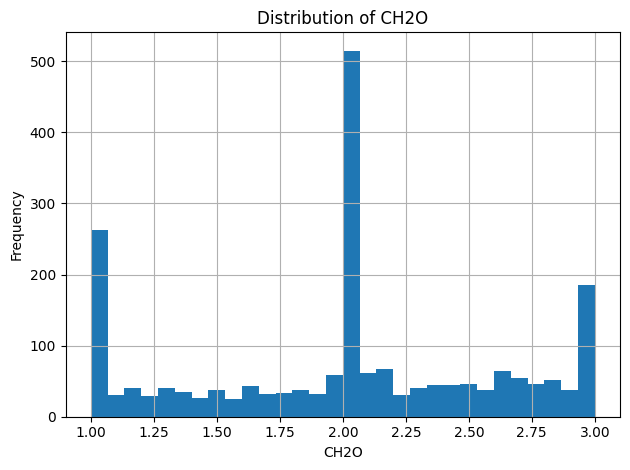

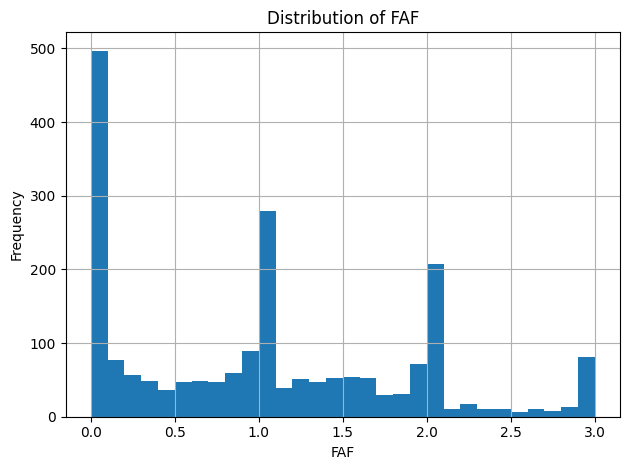

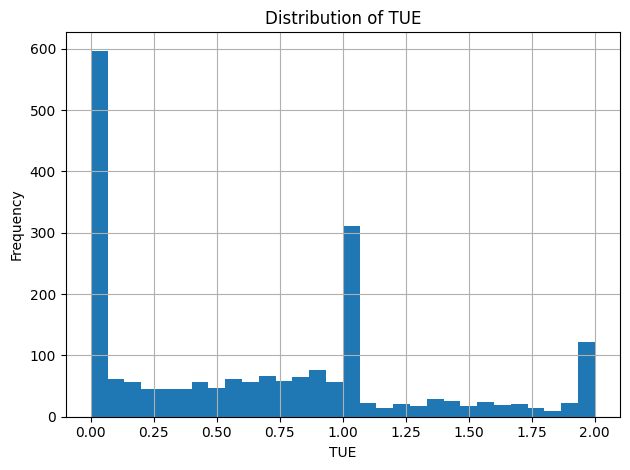

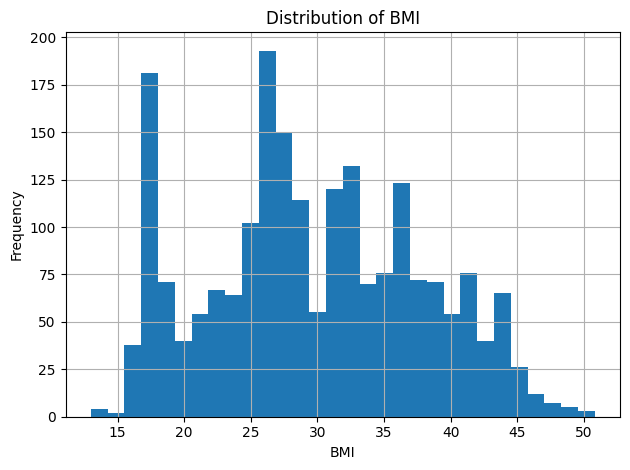

In [71]:
 num_cols = dfc.select_dtypes(include=["number", "Int64"]).columns.tolist()

for col in num_cols:
    dfc[col].dropna().hist(bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

Bivariate Analysis

Demographic Variables with Catagorical Variables

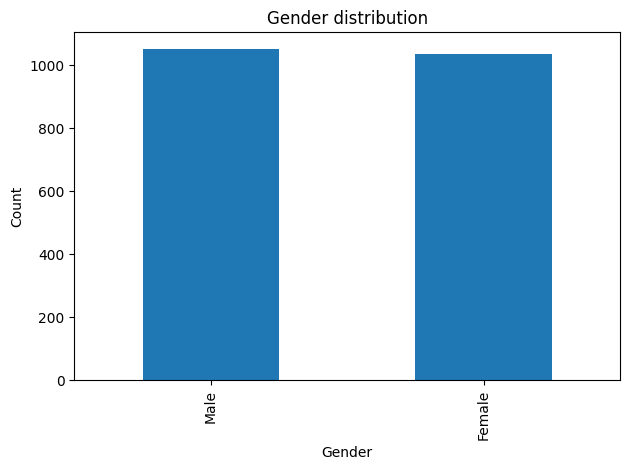

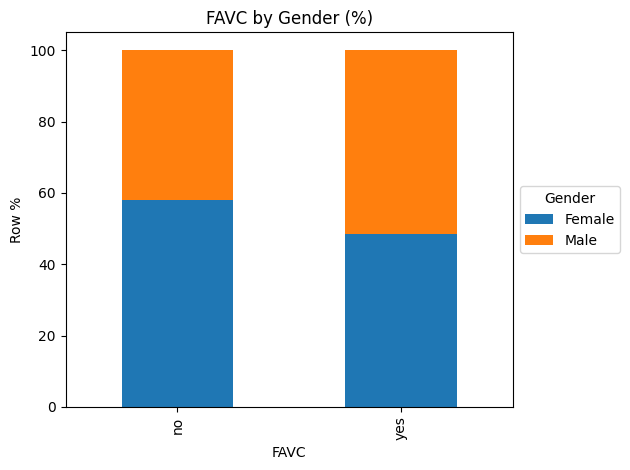

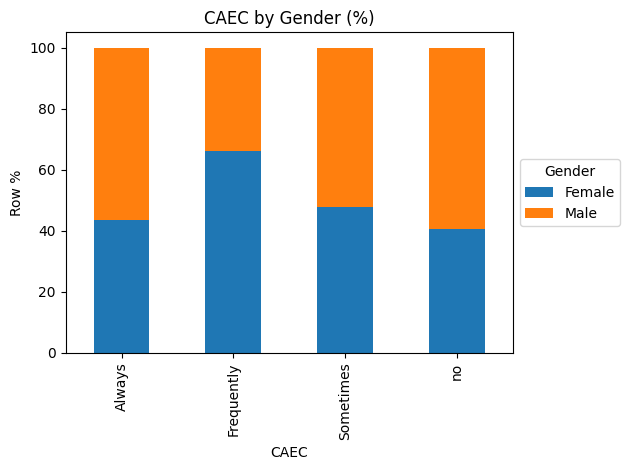

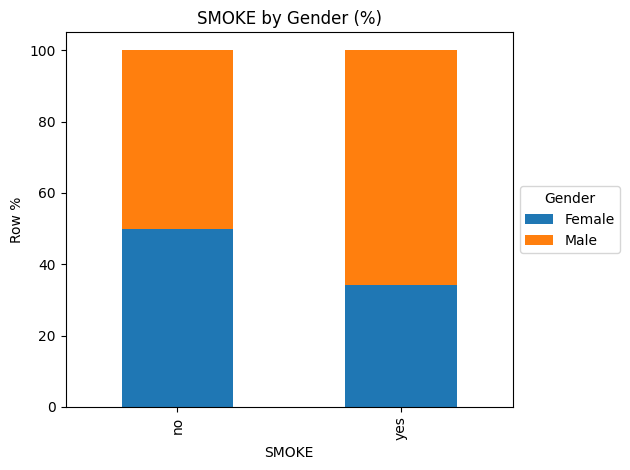

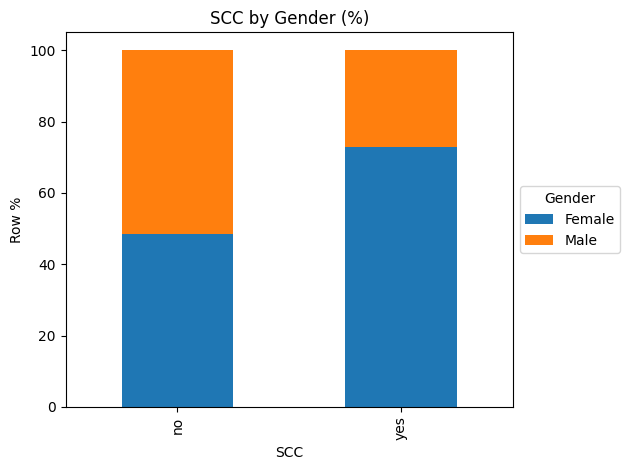

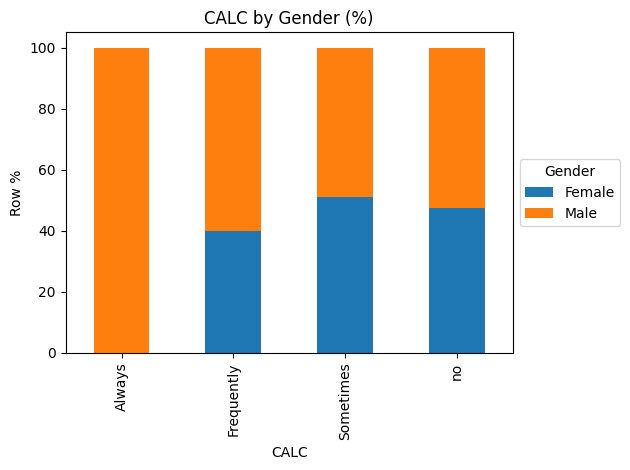

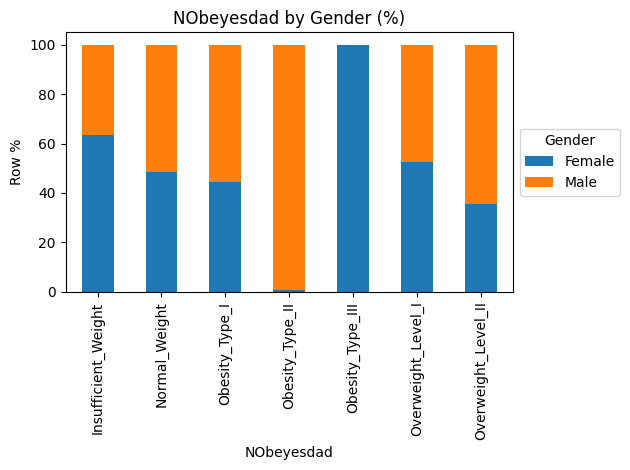

In [72]:
cat_cols = data.select_dtypes(include=["object", "category"]).columns.tolist()
# Ensure Gender is treated as categorical if present
if "Gender" in data.columns and "Gender" not in cat_cols:
    cat_cols.append("Gender")

# Exclude these from the "other categorical" list when crossing
EXCLUDE_FROM_CROSSTABS = {"gender", "age", "agegroup"}  # edit as you like
other_cat = [c for c in cat_cols if c.lower() not in EXCLUDE_FROM_CROSSTABS]

# ---------- helpers ----------
def bar_counts(series, title):
    s = series.astype("string").fillna("Missing").str.strip()
    counts = s.value_counts(dropna=False)
    ax = counts.plot(kind="bar")
    ax.set_title(title)
    ax.set_xlabel(series.name)
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

def stacked_bar_pct(df, row_col, col_col, title=None, top_n=10):
    """
    Stacked % bar of row_col split by col_col.
    Keeps top_n levels of row_col (groups rest into 'Other') for readability.
    """
    a = df[row_col].astype("string").fillna("Missing").str.strip()
    b = df[col_col].astype("string").fillna("Missing").str.strip()

    # keep only top_n categories in the row; group others
    top_levels = a.value_counts().index[:top_n]
    a_reduced = a.where(a.isin(top_levels), other="Other")

    ct = pd.crosstab(a_reduced, b, normalize="index") * 100
    ax = ct.plot(kind="bar", stacked=True)
    ax.set_ylabel("Row %")
    ax.set_xlabel(row_col)
    ax.set_title(title or f"{row_col} by {col_col} (%)")
    ax.legend(title=col_col, loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

# ---------- 1) Demographic distributions ----------
if "Gender" in data.columns:
    bar_counts(data["Gender"], "Gender distribution")

if "AgeGroup" in data.columns:
    bar_counts(data["AgeGroup"], "Age group distribution")

# ---------- 2) Each categorical vs Gender ----------
if "Gender" in data.columns:
    for col in other_cat:
        stacked_bar_pct(data, row_col=col, col_col="Gender",
                        title=f"{col} by Gender (%)", top_n=10)

# ---------- 3) Each categorical vs AgeGroup ----------
if "AgeGroup" in data.columns:
    for col in other_cat:
        stacked_bar_pct(data, row_col=col, col_col="AgeGroup",
                        title=f"{col} by AgeGroup (%)", top_n=10)

Scatter plot Age Vs Numeric

Numeric vs Age correlations:


 -       FCVC: r = 0.014, n = 2087


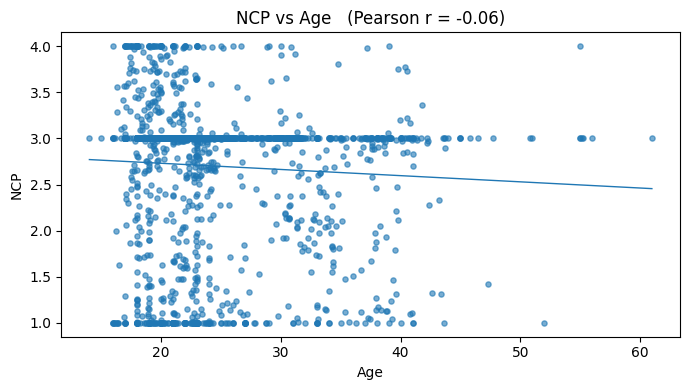

 -        NCP: r = -0.056, n = 2087


 -       CH2O: r = -0.044, n = 2087


 -        FAF: r = -0.148, n = 2087


 -        TUE: r = -0.303, n = 2087


 -        BMI: r = 0.241, n = 2087


In [73]:
# Make Age numeric
data["Age"] = pd.to_numeric(dfc["Age"], errors="coerce")

# Pick numeric columns (exclude Age itself)
num_cols = dfc.select_dtypes(include=["number"]).columns.tolist()
num_cols = [c for c in num_cols if c != "Age"]

# Optional: save each figure as PNG
SAVE_PNG = False

print("Numeric vs Age correlations:")
for col in num_cols:
    dfp = dfc[["Age", col]].dropna()
    if dfp.empty:
        continue

    # Pearson correlation
    r = dfp["Age"].corr(dfp[col])

    # Fit simple linear trend for visual aid
    z = np.polyfit(dfp["Age"], dfp[col], 1)
    xline = np.linspace(dfp["Age"].min(), dfp["Age"].max(), 100)
    yline = z[0]*xline + z[1]

    # Plot (one chart per variable)
    plt.figure(figsize=(7,4))
    plt.scatter(dfp["Age"], dfp[col], s=14, alpha=0.6)
    plt.plot(xline, yline, linewidth=1)   # trendline
    plt.title(f"{col} vs Age   (Pearson r = {r:.2f})")
    plt.xlabel("Age")
    plt.ylabel(col)
    plt.tight_layout()
    if SAVE_PNG:
        plt.savefig(f"scatter_{col}_vs_Age.png", dpi=150, bbox_inches="tight")
    plt.show()

    print(f" - {col:>10}: r = {r:.3f}, n = {len(dfp)}")

Scatterplot BMI vs other Numeric variables

Scatter: BMI vs each numeric feature


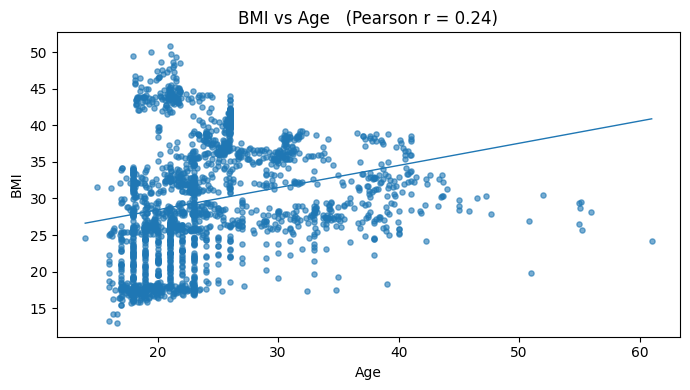

 -        Age: r = 0.241, n = 2087


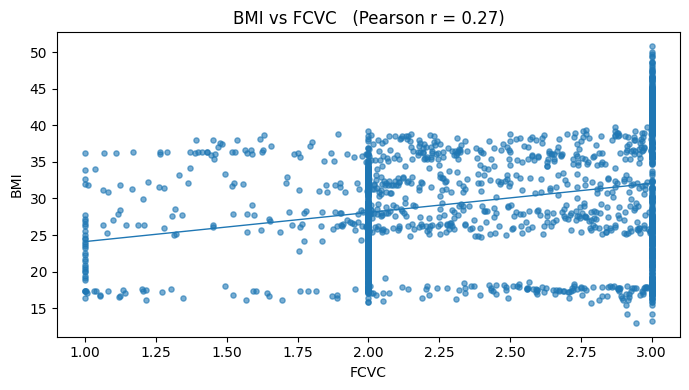

 -       FCVC: r = 0.265, n = 2087


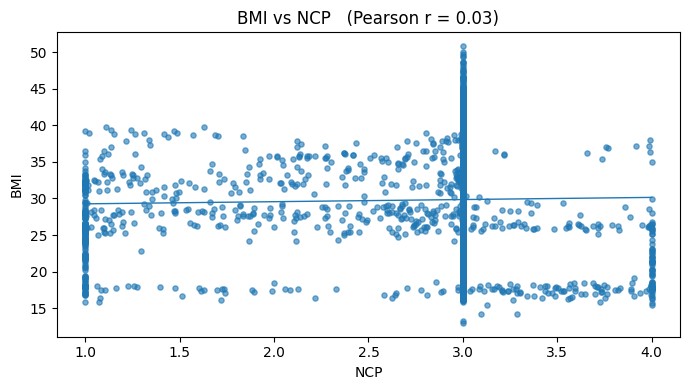

 -        NCP: r = 0.028, n = 2087


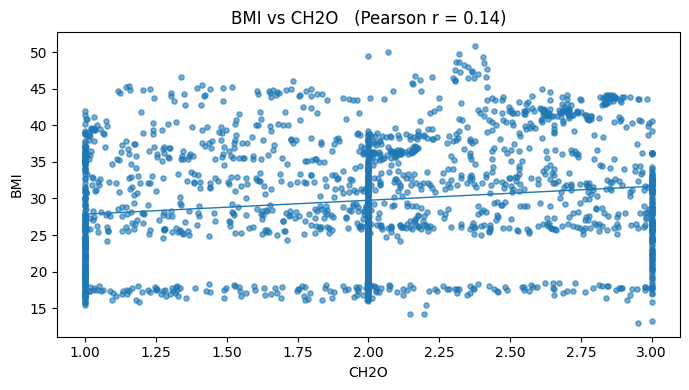

 -       CH2O: r = 0.144, n = 2087


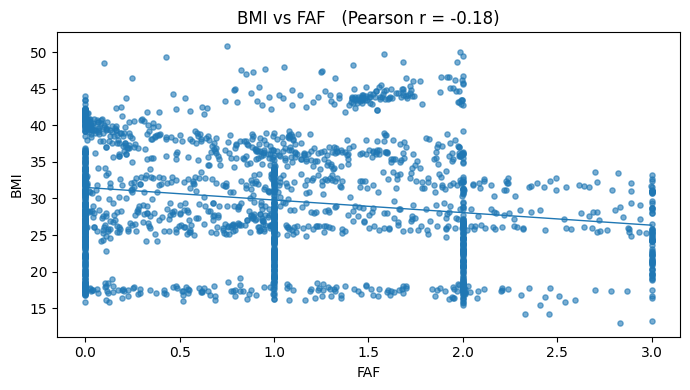

 -        FAF: r = -0.183, n = 2087


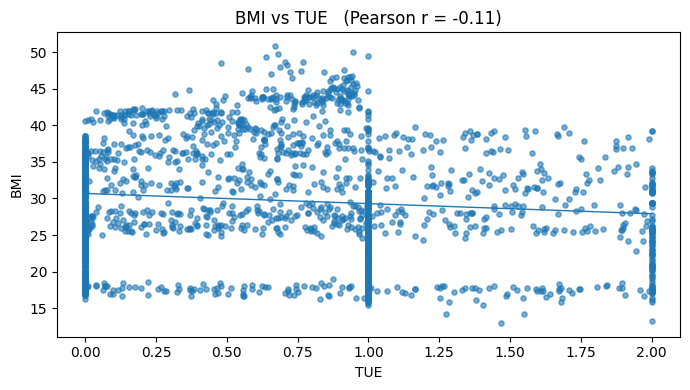

 -        TUE: r = -0.105, n = 2087


In [74]:
# Choose numeric columns (exclude BMI itself; optionally exclude Height/Weight)
num_cols = data.select_dtypes(include=["number"]).columns.tolist()
num_cols = [c for c in num_cols if c != "BMI"]
EXCLUDE_HEIGHT_WEIGHT = True
if EXCLUDE_HEIGHT_WEIGHT:
    num_cols = [c for c in num_cols if c not in ["Height","Weight"]]

# Save figures?
SAVE_PNG = False

print("Scatter: BMI vs each numeric feature")
for col in num_cols:
    dfp = data[["BMI", col]].dropna()
    if dfp.empty:
        continue

    # Pearson correlation
    r = dfp["BMI"].corr(dfp[col])

    # Simple linear trendline (BMI ~ col)
    z = np.polyfit(dfp[col], dfp["BMI"], 1)
    xline = np.linspace(dfp[col].min(), dfp[col].max(), 100)
    yline = z[0]*xline + z[1]

    # Plot
    plt.figure(figsize=(7,4))
    plt.scatter(dfp[col], dfp["BMI"], s=14, alpha=0.6)
    plt.plot(xline, yline, linewidth=1)
    plt.title(f"BMI vs {col}   (Pearson r = {r:.2f})")
    plt.xlabel(col); plt.ylabel("BMI")
    plt.tight_layout()
    if SAVE_PNG:
        plt.savefig(f"scatter_BMI_vs_{col}.png", dpi=150, bbox_inches="tight")
    plt.show()

    print(f" - {col:>10}: r = {r:.3f}, n = {len(dfp)}")

Mulivariate Analysis

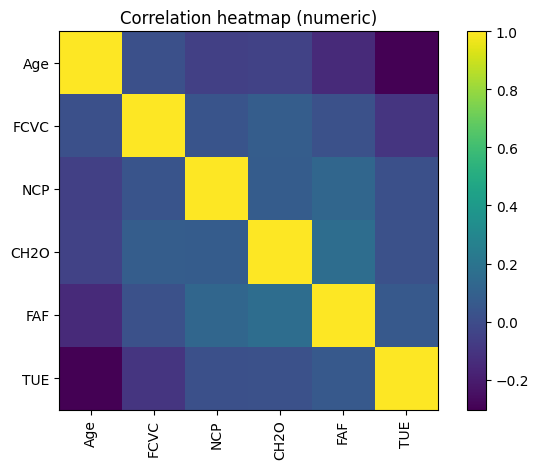

In [75]:
# ---------- Correlation heatmap ----------
if len(num_cols) >= 2:
    corr = dfc[num_cols].corr()
    plt.imshow(corr, interpolation="nearest")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation heatmap (numeric)")
    plt.colorbar(); plt.tight_layout()
    if SAVE_PNG: plt.savefig("corr_heatmap.png", dpi=150)
    plt.show()


Age by BMI:


count       mean  std     median        min        max
BMI                                                              
12.998685      1  16.611837  NaN  16.611837  16.611837  16.611837
13.291588      1  16.000000  NaN  16.000000  16.000000  16.000000
14.160575      1  16.613108  NaN  16.613108  16.613108  16.613108
14.253876      1  16.270434  NaN  16.270434  16.270434  16.270434
15.432099      1  17.000000  NaN  17.000000  17.000000  17.000000
...          ...        ...  ...        ...        ...        ...
49.378120      1  21.521294  NaN  21.521294  21.521294  21.521294
49.472390      1  18.000000  NaN  18.000000  18.000000  18.000000
49.699918      1  21.131526  NaN  21.131526  21.131526  21.131526
50.014023      1  19.472190  NaN  19.472190  19.472190  19.472190
50.811753      1  21.056059  NaN  21.056059  21.056059  21.056059

[1968 rows x 6 columns]

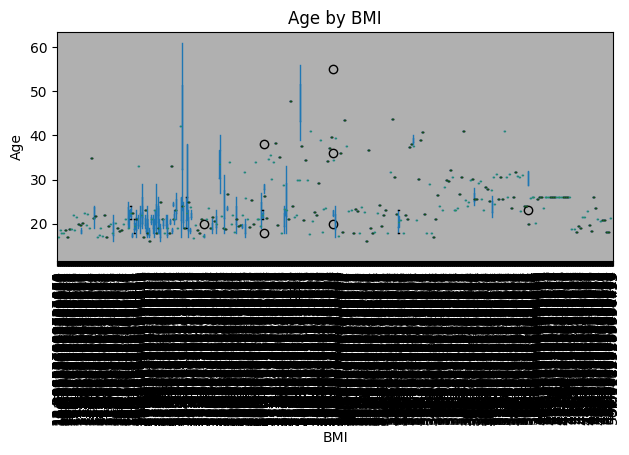


FCVC by BMI:


count      mean  std    median       min       max
BMI                                                          
12.998685      1  2.945967  NaN  2.945967  2.945967  2.945967
13.291588      1  3.000000  NaN  3.000000  3.000000  3.000000
14.160575      1  2.911877  NaN  2.911877  2.911877  2.911877
14.253876      1  3.000000  NaN  3.000000  3.000000  3.000000
15.432099      1  3.000000  NaN  3.000000  3.000000  3.000000
...          ...       ...  ...       ...       ...       ...
49.378120      1  3.000000  NaN  3.000000  3.000000  3.000000
49.472390      1  3.000000  NaN  3.000000  3.000000  3.000000
49.699918      1  3.000000  NaN  3.000000  3.000000  3.000000
50.014023      1  3.000000  NaN  3.000000  3.000000  3.000000
50.811753      1  3.000000  NaN  3.000000  3.000000  3.000000

[1968 rows x 6 columns]

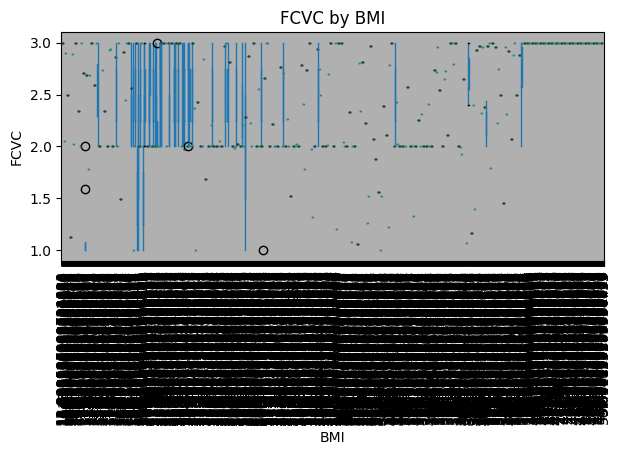


NCP by BMI:


count      mean  std    median       min       max
BMI                                                          
12.998685      1  3.000000  NaN  3.000000  3.000000  3.000000
13.291588      1  3.000000  NaN  3.000000  3.000000  3.000000
14.160575      1  3.098399  NaN  3.098399  3.098399  3.098399
14.253876      1  3.286431  NaN  3.286431  3.286431  3.286431
15.432099      1  4.000000  NaN  4.000000  4.000000  4.000000
...          ...       ...  ...       ...       ...       ...
49.378120      1  3.000000  NaN  3.000000  3.000000  3.000000
49.472390      1  3.000000  NaN  3.000000  3.000000  3.000000
49.699918      1  3.000000  NaN  3.000000  3.000000  3.000000
50.014023      1  3.000000  NaN  3.000000  3.000000  3.000000
50.811753      1  3.000000  NaN  3.000000  3.000000  3.000000

[1968 rows x 6 columns]

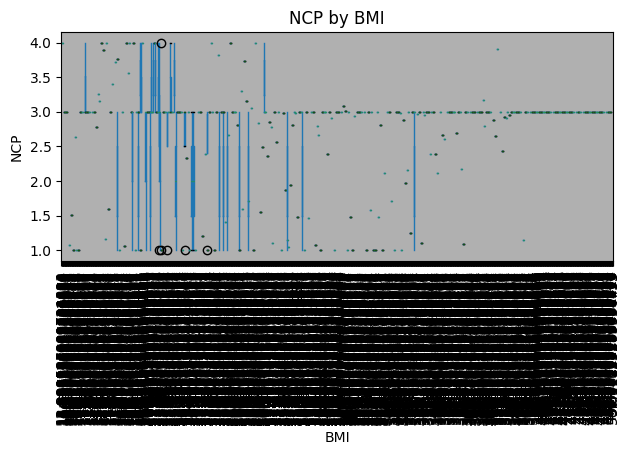


CH2O by BMI:


count      mean  std    median       min       max
BMI                                                          
12.998685      1  2.953192  NaN  2.953192  2.953192  2.953192
13.291588      1  3.000000  NaN  3.000000  3.000000  3.000000
14.160575      1  2.196405  NaN  2.196405  2.196405  2.196405
14.253876      1  2.148146  NaN  2.148146  2.148146  2.148146
15.432099      1  1.000000  NaN  1.000000  1.000000  1.000000
...          ...       ...  ...       ...       ...       ...
49.378120      1  2.404049  NaN  2.404049  2.404049  2.404049
49.472390      1  2.000000  NaN  2.000000  2.000000  2.000000
49.699918      1  2.319912  NaN  2.319912  2.319912  2.319912
50.014023      1  2.069257  NaN  2.069257  2.069257  2.069257
50.811753      1  2.374958  NaN  2.374958  2.374958  2.374958

[1968 rows x 6 columns]

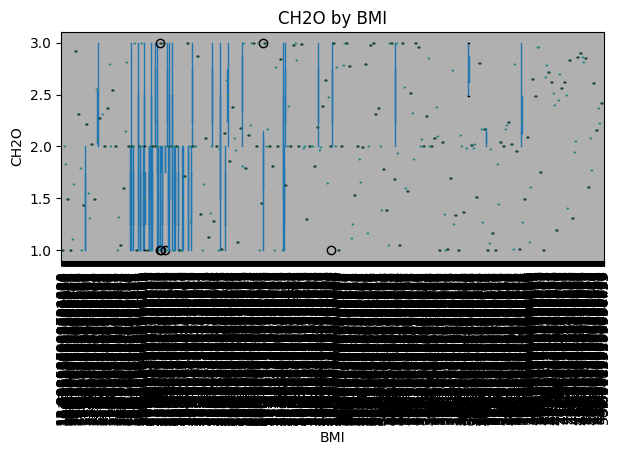


FAF by BMI:


count      mean  std    median       min       max
BMI                                                          
12.998685      1  2.830911  NaN  2.830911  2.830911  2.830911
13.291588      1  3.000000  NaN  3.000000  3.000000  3.000000
14.160575      1  2.328147  NaN  2.328147  2.328147  2.328147
14.253876      1  2.458237  NaN  2.458237  2.458237  2.458237
15.432099      1  2.000000  NaN  2.000000  2.000000  2.000000
...          ...       ...  ...       ...       ...       ...
49.378120      1  0.427905  NaN  0.427905  0.427905  0.427905
49.472390      1  2.000000  NaN  2.000000  2.000000  2.000000
49.699918      1  1.582675  NaN  1.582675  1.582675  1.582675
50.014023      1  1.986646  NaN  1.986646  1.986646  1.986646
50.811753      1  0.750111  NaN  0.750111  0.750111  0.750111

[1968 rows x 6 columns]


TUE by BMI:


count      mean  std    median       min       max
BMI                                                          
12.998685      1  1.466667  NaN  1.466667  1.466667  1.466667
13.291588      1  2.000000  NaN  2.000000  2.000000  2.000000
14.160575      1  1.550110  NaN  1.550110  1.550110  1.550110
14.253876      1  1.273333  NaN  1.273333  1.273333  1.273333
15.432099      1  1.000000  NaN  1.000000  1.000000  1.000000
...          ...       ...  ...       ...       ...       ...
49.378120      1  0.639894  NaN  0.639894  0.639894  0.639894
49.472390      1  1.000000  NaN  1.000000  1.000000  1.000000
49.699918      1  0.680746  NaN  0.680746  0.680746  0.680746
50.014023      1  0.947091  NaN  0.947091  0.947091  0.947091
50.811753      1  0.671458  NaN  0.671458  0.671458  0.671458

[1968 rows x 6 columns]

In [76]:
# ---------- Numeric vs Target (grouped stats + boxplots) ----------
if target:
    for col in num_cols:
        tbl = dfc.groupby(target)[col].agg(["count","mean","std","median","min","max"])
        print(f"\n{col} by {target}:")
        display(tbl)
        try:
            dfc.boxplot(column=col, by=target, rot=90)
            plt.title(f"{col} by {target}"); plt.suptitle("")
            plt.xlabel(target); plt.ylabel(col); plt.tight_layout()
            if SAVE_PNG: plt.savefig(f"box_{col}_by_target.png", dpi=150)
            plt.show()
        except Exception as e:
            print(f"(Could not boxplot {col}: {e})")

Annomalies Treatment

In [78]:
# ===== Treat anomalies: rule-based caps + IQR winsorization =====
import numpy as np, pandas as pd

# Use your cleaned dfc if available, else df
X = dfc.copy() if "dfc" in globals() else df.copy()


# Ensure numeric for likely continuous fields; create BMI if missing
for c in ["Age","Height","Weight","NCP","CH2O","FAF","FCVC","TUE"]:
    if c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
if {"Height","Weight"}.issubset(X.columns) and "BMI" not in X.columns:
    X["BMI"] = X["Weight"] / (X["Height"]**2)

# ---------- 1) RULE-BASED BOUNDS (domain) ----------
# (Tweak bounds if your instructor provided specific scales)
bounds = {
    "Age":   (10, 90),          # yrs
    "Height":(1.2, 2.2),        # meters
    "Weight":(30, 250),         # kg
    "BMI":   (12, 60),          # kg/m^2 (practical)
    # survey scales
    "FCVC":  (1, 3),            # veggies freq
    "NCP":   (1, 4),            # main meals/day
    "CH2O":  (1, 3),            # water consumption
    "FAF":   (0, 3),            # physical activity
    "TUE":   (0, 2),            # tech use
}

rule_log = {}
for col, (lo, hi) in bounds.items():
    if col in X.columns:
        s = X[col].copy()
        before_low  = (s < lo).sum()
        before_high = (s > hi).sum()
        X[col] = s.clip(lo, hi)
        rule_log[col] = {"capped_low": int(before_low), "capped_high": int(before_high)}

print("Rule-based caps applied:")
for k,v in rule_log.items():
    print(f" - {k:>5}: low→{v['capped_low']}, high→{v['capped_high']}")

# ---------- 2) DISTRIBUTION-BASED WINSORIZATION (IQR) ----------
def winsorize_iqr(series, k=1.5):
    s = pd.to_numeric(series, errors="coerce")
    q1 = s.quantile(0.25); q3 = s.quantile(0.75)
    iqr = q3 - q1
    lo  = q1 - k*iqr
    hi  = q3 + k*iqr
    s2  = s.clip(lo, hi)
    return s2, lo, hi, int((s < lo).sum()), int((s > hi).sum())

iqr_cols = [c for c in ["Age","Height","Weight","BMI"] if c in X.columns]
iqr_log = {}
for col in iqr_cols:
    X[col], lo, hi, nlow, nhigh = winsorize_iqr(X[col], k=1.5)
    iqr_log[col] = {"iqr_low": nlow, "iqr_high": nhigh, "lo": float(lo), "hi": float(hi)}

print("\nIQR winsorization (after rule caps):")
for k,v in iqr_log.items():
    print(f" - {k:>6}: low→{v['iqr_low']}, high→{v['iqr_high']} | fences [{v['lo']:.2f}, {v['hi']:.2f}]")

# Optional: round survey scales back to neat steps
for col in ["FCVC","NCP","CH2O","FAF","TUE"]:
    if col in X.columns:
        X[col] = X[col].round(0)

# Keep a copy to continue modeling
df_anom_treated = X.copy()
print("\nAnomaly treatment complete. Use `df_anom_treated` going forward.")


Rule-based caps applied:
 -   Age: low→0, high→0
 -   BMI: low→0, high→0
 -  FCVC: low→0, high→0
 -   NCP: low→0, high→0
 -  CH2O: low→0, high→0
 -   FAF: low→0, high→0
 -   TUE: low→0, high→0

IQR winsorization (after rule caps):
 -    Age: low→0, high→167 | fences [10.79, 35.13]
 -    BMI: low→0, high→0 | fences [6.78, 53.69]

Anomaly treatment complete. Use `df_anom_treated` going forward.


Feature Engineering

cluster_rank  centroid_BMI range_BMI_[lo,hi)  empirical_min  empirical_max  \
0             0         17.78     [-inf, 20.32)          13.00          20.31   
1             1         22.86    [20.32, 24.98)          20.32          24.95   
2             2         27.10    [24.98, 29.57)          25.00          29.56   
3             3         32.03    [29.57, 34.16)          29.57          34.16   
4             4         36.28    [34.16, 38.35)          34.16          38.31   
5             5         40.42    [38.35, 42.55)          38.36          42.51   
6             6         44.69      [42.55, inf)          42.73          50.81   

     n  majority_NObeyesdad  majority_%  
0  332  Insufficient_Weight        80.4  
1  229        Normal_Weight        94.8  
2  541  Overweight_Level_II        51.2  
3  347       Obesity_Type_I        95.4  
4  285      Obesity_Type_II        86.7  
5  217     Obesity_Type_III        78.3  
6  136     Obesity_Type_III       100.0

cluster_rank  centroid_BMI range_BMI_[lo,hi)  empirical_min  empirical_max  \
0             0         17.78     [-inf, 20.32)          13.00          20.31   
1             1         22.86    [20.32, 24.98)          20.32          24.95   
2             2         27.10    [24.98, 29.57)          25.00          29.56   
3             3         32.03    [29.57, 34.16)          29.57          34.16   
4             4         36.28    [34.16, 38.35)          34.16          38.31   
5             5         40.42    [38.35, 42.55)          38.36          42.51   
6             6         44.69      [42.55, inf)          42.73          50.81   

     n  majority_NObeyesdad  majority_%      suggested_label  
0  332  Insufficient_Weight        80.4  Insufficient_Weight  
1  229        Normal_Weight        94.8        Normal_Weight  
2  541  Overweight_Level_II        51.2   Overweight_Level_I  
3  347       Obesity_Type_I        95.4  Overweight_Level_II  
4  285      Obesity_Type_II        86.7       Obesity_Type_I  
5  217     Obesity_Type_III        78.3      Obesity_Type_II  
6  136     Obesity_Type_III       100.0     Obesity_Type_III

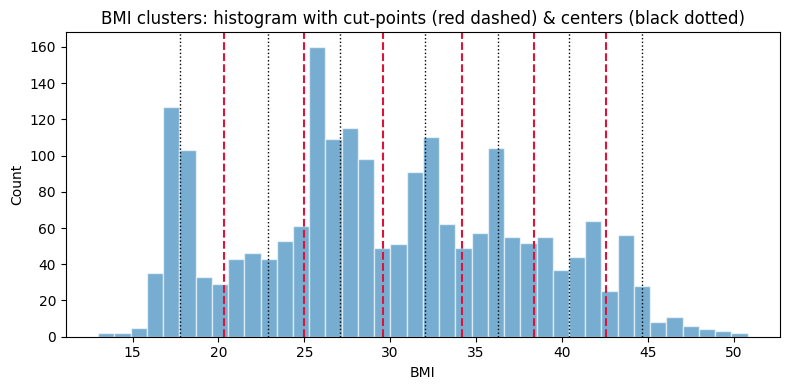


Row % crosstab of NObeyesdad vs KMeans-order labels (by BMI):


cluster_label_ordered  Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
NObeyesdad                                                                  
Insufficient_Weight                  100.0            0.0             0.0   
Normal_Weight                         23.0           77.0             0.0   
Obesity_Type_I                         0.0            0.0             5.7   
Obesity_Type_II                        0.0            0.0            83.2   
Obesity_Type_III                       0.0            0.0             5.6   
Overweight_Level_I                     0.0            4.3             0.0   
Overweight_Level_II                    0.0            0.0             0.0   

cluster_label_ordered  Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
NObeyesdad                                                                     
Insufficient_Weight                0.0               0.0                 0.0   
Normal_Weight                      0.0               0.0                 0.0   
Obesity_Type_I                     0.0               0.0                 0.0   
Obesity_Type_II                   15.8               0.0                 0.0   
Obesity_Type_III                  52.5              42.0                 0.0   
Overweight_Level_I                 0.0               0.0                95.7   
Overweight_Level_II                0.0               0.0                95.5   

cluster_label_ordered  Overweight_Level_II  
NObeyesdad                                  
Insufficient_Weight                    0.0  
Normal_Weight                          0.0  
Obesity_Type_I                        94.3  
Obesity_Type_II                        1.0  
Obesity_Type_III                       0.0  
Overweight_Level_I                     0.0  
Overweight_Level_II                    4.5

In [79]:
# =========================
# Cluster BMI and read lower/upper cut-points
# =========================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

# 0) Data — use dfc if available; else df
D = dfc.copy() if "dfc" in globals() else df.copy()

# Ensure BMI exists & numeric
for c in ["Height","Weight"]:
    if c in D.columns:
        D[c] = pd.to_numeric(D[c], errors="coerce")
if {"Height","Weight"}.issubset(D.columns) and "BMI" not in D.columns:
    D["BMI"] = D["Weight"] / (D["Height"]**2)
D["BMI"] = pd.to_numeric(D["BMI"], errors="coerce")

# Optional: clip extreme BMIs to avoid a few points dominating 1-D kmeans
BMI_CLIP = (12, 60)
bmi = D["BMI"].clip(*BMI_CLIP).dropna().to_numpy().reshape(-1, 1)

# 1) KMeans on BMI (1-D)
K = 7  # set to 7 to match NObeyesdad levels; you can try 6 or 5 if desired
km = KMeans(n_clusters=K, random_state=42, n_init="auto")
labels = km.fit_predict(bmi)
centers = km.cluster_centers_.ravel()

# 2) Sort clusters by BMI (low -> high) and compute boundaries
order = np.argsort(centers)
cent_sorted = centers[order]
# boundaries are midpoints between adjacent centroids
bounds = [(cent_sorted[i] + cent_sorted[i+1]) / 2 for i in range(K-1)]
bounds = np.array(bounds)

# Map each point to its position in the sorted order (0..K-1)
inv_order = {orig:i for i, orig in enumerate(order)}
sorted_labels = np.array([inv_order[l] for l in labels])

# 3) Build a summary table with empirical mins/maxes and majority NObeyesdad
# attach back to the rows we used
tmp = D.loc[D["BMI"].notna(), ["BMI", "NObeyesdad"]].copy()
tmp["BMI"] = tmp["BMI"].clip(*BMI_CLIP).to_numpy()
tmp["cluster"] = sorted_labels

rows = []
for k in range(K):
    members = tmp.loc[tmp["cluster"]==k]
    lo_emp, hi_emp = members["BMI"].min(), members["BMI"].max()
    lo_theo = -np.inf if k==0 else bounds[k-1]
    hi_theo =  np.inf if k==K-1 else bounds[k]
    maj_label, maj_share = None, np.nan
    if "NObeyesdad" in tmp.columns:
        vc = members["NObeyesdad"].value_counts(normalize=True)
        if len(vc):
            maj_label, maj_share = vc.index[0], float(vc.iloc[0]*100)
    rows.append({
        "cluster_rank": k,
        "centroid_BMI": round(cent_sorted[k], 2),
        "range_BMI_[lo,hi)": f"[{lo_theo:.2f}, {hi_theo:.2f})",
        "empirical_min": round(lo_emp, 2),
        "empirical_max": round(hi_emp, 2),
        "n": int(len(members)),
        "majority_NObeyesdad": maj_label if maj_label is not None else "",
        "majority_%": round(maj_share, 1) if not np.isnan(maj_share) else ""
    })

summary = pd.DataFrame(rows)
display(summary)

# 4) Suggested mapping from low->high cluster to dataset labels
suggested = [
    "Insufficient_Weight",
    "Normal_Weight",
    "Overweight_Level_I",
    "Overweight_Level_II",
    "Obesity_Type_I",
    "Obesity_Type_II",
    "Obesity_Type_III",
][:K]
summary["suggested_label"] = suggested
display(summary)

# 5) Histogram with boundaries & centroids
plt.figure(figsize=(8,4))
plt.hist(bmi.ravel(), bins=40, alpha=0.6, edgecolor="white")
for x in bounds:
    plt.axvline(x, color="crimson", linestyle="--", linewidth=1.5)
for c in cent_sorted:
    plt.axvline(c, color="black", linestyle=":", linewidth=1)
plt.title("BMI clusters: histogram with cut-points (red dashed) & centers (black dotted)")
plt.xlabel("BMI"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# 6) (Optional) Evaluate agreement with NObeyesdad via majority vote mapping
if "NObeyesdad" in tmp.columns:
    # Map each cluster to suggested label purely by order; compare
    tmp["cluster_label_ordered"] = tmp["cluster"].map({i: suggested[i] for i in range(K)})
    ct = pd.crosstab(tmp["NObeyesdad"], tmp["cluster_label_ordered"], normalize="index")*100
    print("\nRow % crosstab of NObeyesdad vs KMeans-order labels (by BMI):")
    display(ct.round(1))


Bar Chart (BMI vs Catagorical Variables)

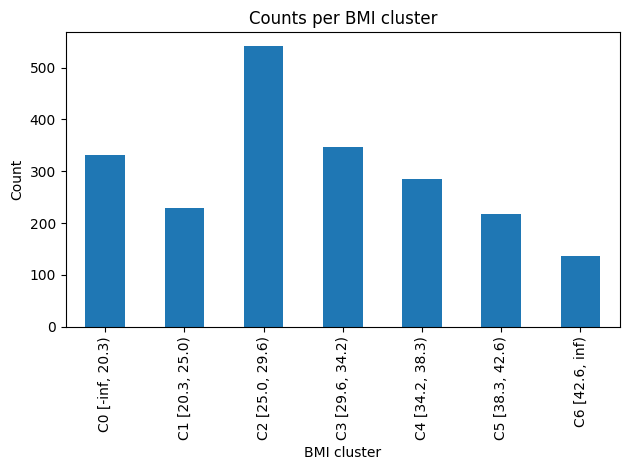

Categoricals to plot: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


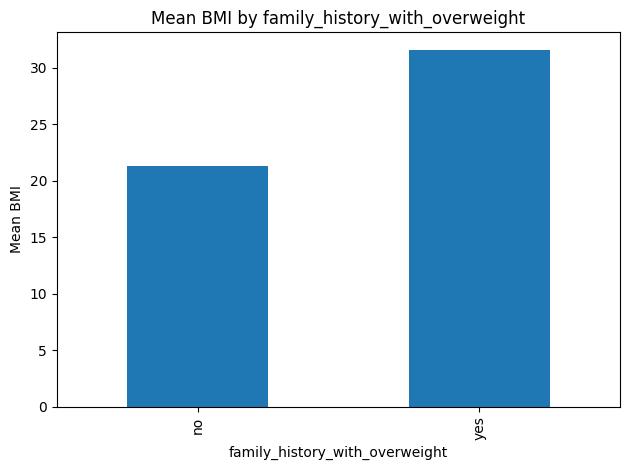

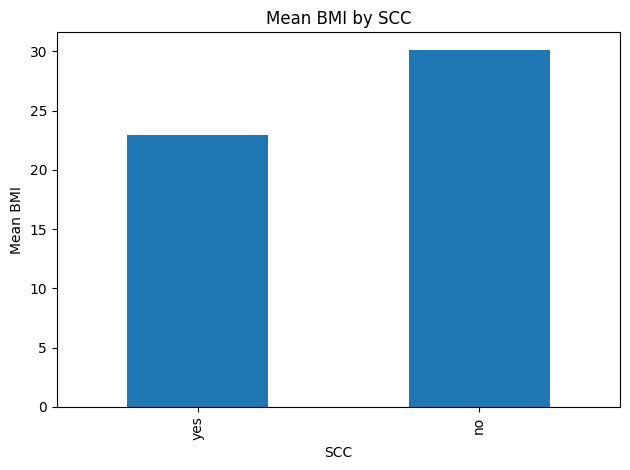

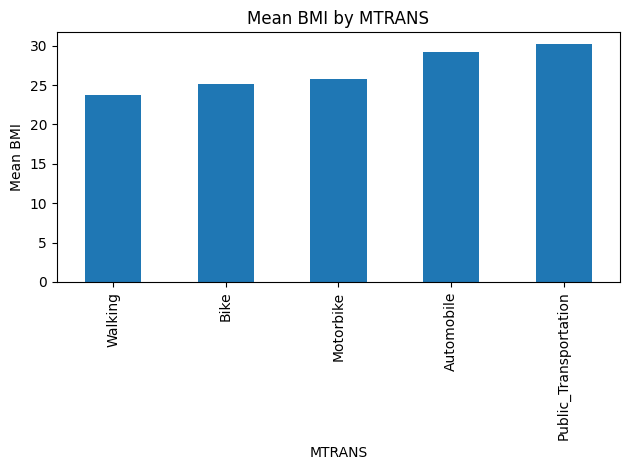

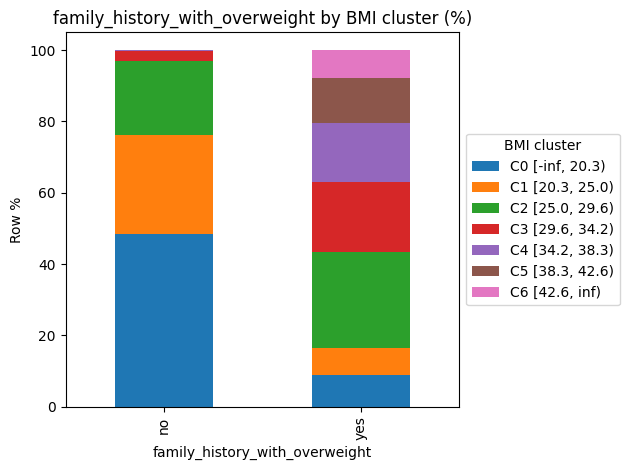

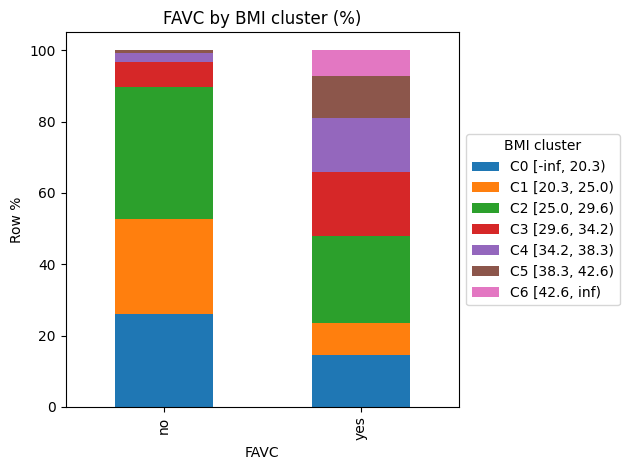

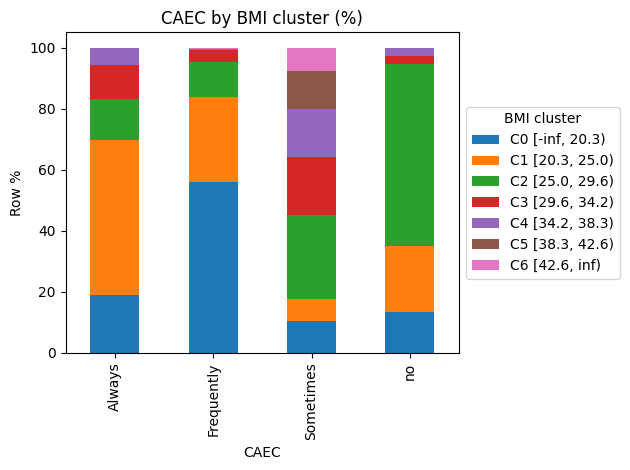

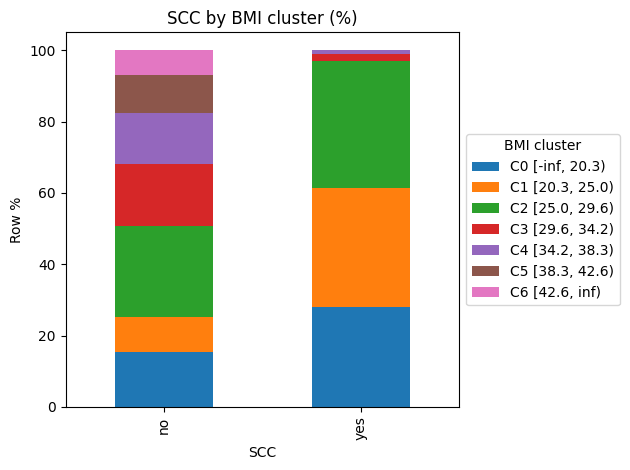

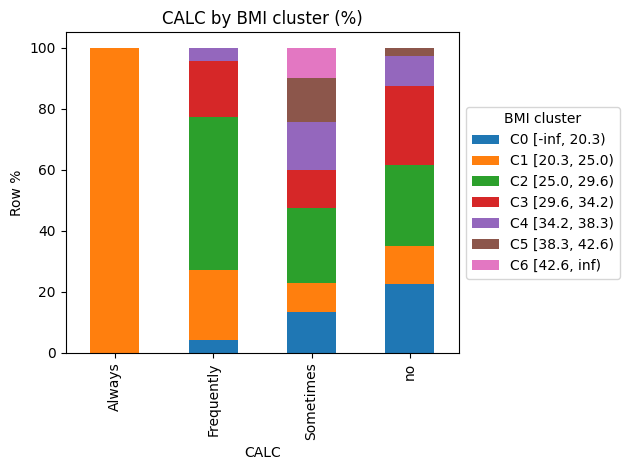

In [83]:
# ============================================
# Bar charts: BMI (clustered) vs categorical variables
# - counts per BMI cluster
# - mean BMI by category
# - stacked % bars of each category split by BMI cluster
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Build a working frame aligned with your clustering
tmp_all = D.loc[D["BMI"].notna()].copy()
tmp_all["BMI_clean"] = tmp_all["BMI"].clip(*BMI_CLIP)
tmp_all["BMI_cluster"] = sorted_labels  # 0..K-1 from your code

# Readable cluster names using learned cut-points
edges = np.concatenate(([-np.inf], bounds, [np.inf]))
cluster_names = [f"C{i} [{edges[i]:.1f}, {edges[i+1]:.1f})" for i in range(K)]
cluster_map = {i: cluster_names[i] for i in range(K)}
tmp_all["BMI_cluster_name"] = tmp_all["BMI_cluster"].map(cluster_map)

# ---------- 0) Counts per BMI cluster ----------
counts = tmp_all["BMI_cluster_name"].value_counts().reindex(cluster_names, fill_value=0)
ax = counts.plot(kind="bar")
ax.set_title("Counts per BMI cluster")
ax.set_xlabel("BMI cluster"); ax.set_ylabel("Count")
plt.tight_layout(); plt.show()

# ---------- helpers ----------
def bar_mean_bmi_by_category(df, cat_col):
    s = df[cat_col].astype("string").fillna("Missing").str.strip()
    means = df.groupby(s)["BMI_clean"].mean().sort_values()
    ax = means.plot(kind="bar")
    ax.set_title(f"Mean BMI by {cat_col}")
    ax.set_xlabel(cat_col); ax.set_ylabel("Mean BMI")
    plt.tight_layout(); plt.show()

def stacked_bar_pct_by_cluster(df, cat_col, top_n=10):
    a = df[cat_col].astype("string").fillna("Missing").str.strip()
    # keep only top_n levels to keep the chart readable
    if top_n and a.nunique() > top_n:
        top = a.value_counts().index[:top_n]
        a = a.where(a.isin(top), other="Other")
    ct = pd.crosstab(a, df["BMI_cluster_name"], normalize="index") * 100
    ct = ct.reindex(columns=cluster_names)  # keep cluster order
    ax = ct.plot(kind="bar", stacked=True)
    ax.set_title(f"{cat_col} by BMI cluster (%)")
    ax.set_xlabel(cat_col); ax.set_ylabel("Row %")
    ax.legend(title="BMI cluster", loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout(); plt.show()

# ---------- pick categorical columns ----------
cat_cols = tmp_all.select_dtypes(include=["object", "category"]).columns.tolist()
# drop helper columns and obvious non-features if present; edit as you like
exclude = {"bmi_cluster_name", "nobeyesdad"}  # keep/ remove NObeyesdad as you prefer
cat_cols = [c for c in cat_cols if c.lower() not in exclude]

print("Categoricals to plot:", cat_cols)

# ---------- 1) Mean BMI bars per category ----------
for col in cat_cols:
    bar_mean_bmi_by_category(tmp_all, col)

# ---------- 2) Stacked % bars: each category split by BMI cluster ----------
for col in cat_cols:
    stacked_bar_pct_by_cluster(tmp_all, col, top_n=10)


BMI vs Numerical Variables


Age by BMI_Group:


count    mean    std  median      q1      q3   min  \
BMI_Group                                                                 
Insufficient_Weight    266  19.739  2.637  19.151  18.000  21.000  16.0   
Normal_Weight          295  21.834  5.329  21.000  19.000  23.000  14.0   
Overweight_Level_I     320  24.408  6.693  21.824  19.721  27.225  16.0   
Overweight_Level_II    232  26.651  7.980  23.595  21.000  32.840  17.0   
Obesity_Type_I         368  25.854  7.671  23.000  20.963  29.626  15.0   
Obesity_Type_II        338  27.967  4.631  25.999  25.018  30.605  20.0   
Obesity_Type_III       268  23.033  2.821  22.812  20.887  26.000  18.0   

                        max  
BMI_Group                    
Insufficient_Weight  39.000  
Normal_Weight        61.000  
Overweight_Level_I   55.246  
Overweight_Level_II  56.000  
Obesity_Type_I       52.000  
Obesity_Type_II      41.000  
Obesity_Type_III     26.000

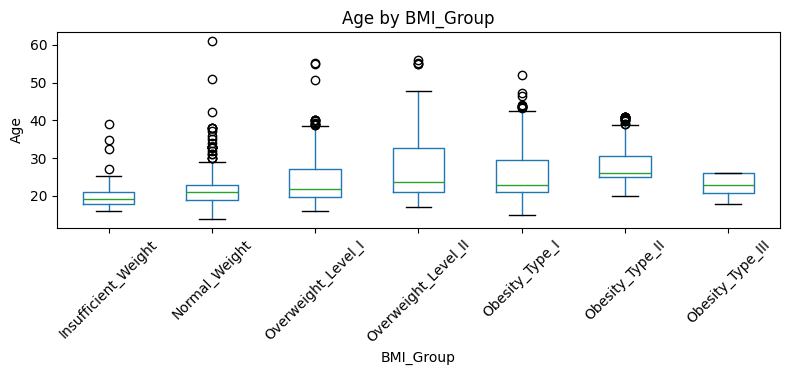


FCVC by BMI_Group:


count   mean    std  median     q1     q3  min  max
BMI_Group                                                               
Insufficient_Weight    266  2.467  0.587   2.688  2.000  3.000  1.0  3.0
Normal_Weight          295  2.334  0.590   2.000  2.000  3.000  1.0  3.0
Overweight_Level_I     320  2.297  0.502   2.041  2.000  2.838  1.0  3.0
Overweight_Level_II    232  2.230  0.427   2.000  2.000  2.575  1.0  3.0
Obesity_Type_I         368  2.207  0.431   2.000  2.000  2.485  1.0  3.0
Obesity_Type_II        338  2.486  0.510   2.612  2.137  2.998  1.0  3.0
Obesity_Type_III       268  3.000  0.000   3.000  3.000  3.000  3.0  3.0

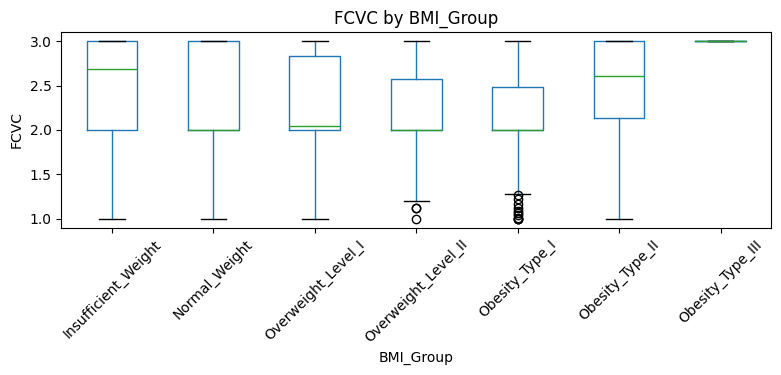


NCP by BMI_Group:


count   mean    std  median     q1     q3  min    max
BMI_Group                                                                 
Insufficient_Weight    266  2.936  0.876   3.000  3.000  3.534  1.0  4.000
Normal_Weight          295  2.736  0.872   3.000  3.000  3.000  1.0  4.000
Overweight_Level_I     320  2.592  0.885   3.000  2.114  3.000  1.0  4.000
Overweight_Level_II    232  2.456  0.780   2.906  1.832  3.000  1.0  4.000
Obesity_Type_I         368  2.454  0.774   3.000  1.865  3.000  1.0  3.087
Obesity_Type_II        338  2.790  0.546   3.000  2.917  3.000  1.0  4.000
Obesity_Type_III       268  3.000  0.000   3.000  3.000  3.000  3.0  3.000

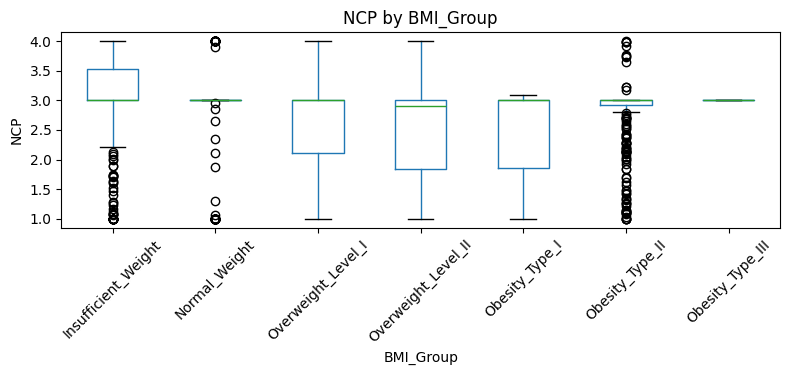


CH2O by BMI_Group:


count   mean    std  median     q1     q3  min  max
BMI_Group                                                               
Insufficient_Weight    266  1.883  0.599   2.000  1.317  2.228  1.0  3.0
Normal_Weight          295  1.851  0.630   2.000  1.000  2.000  1.0  3.0
Overweight_Level_I     320  2.035  0.588   2.000  1.731  2.430  1.0  3.0
Overweight_Level_II    232  2.022  0.559   2.000  1.739  2.272  1.0  3.0
Obesity_Type_I         368  2.117  0.623   2.018  1.768  2.657  1.0  3.0
Obesity_Type_II        338  1.841  0.561   2.000  1.341  2.166  1.0  3.0
Obesity_Type_III       268  2.296  0.552   2.499  1.818  2.708  1.0  3.0

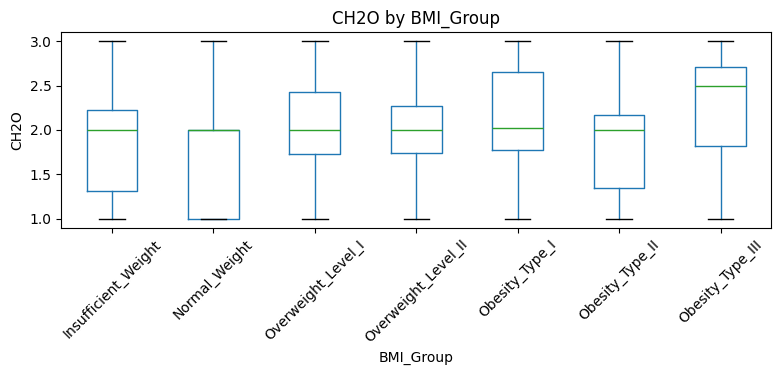


FAF by BMI_Group:


count   mean    std  median     q1     q3  min  max
BMI_Group                                                               
Insufficient_Weight    266  1.276  0.849   1.399  0.493  2.000  0.0  3.0
Normal_Weight          295  1.223  1.023   1.000  0.000  2.000  0.0  3.0
Overweight_Level_I     320  1.069  0.840   1.000  0.365  1.736  0.0  3.0
Overweight_Level_II    232  0.927  0.850   0.930  0.090  1.325  0.0  3.0
Obesity_Type_I         368  1.005  0.875   1.000  0.065  1.646  0.0  3.0
Obesity_Type_II        338  0.826  0.627   0.859  0.205  1.278  0.0  2.0
Obesity_Type_III       268  0.774  0.760   0.622  0.000  1.507  0.0  2.0

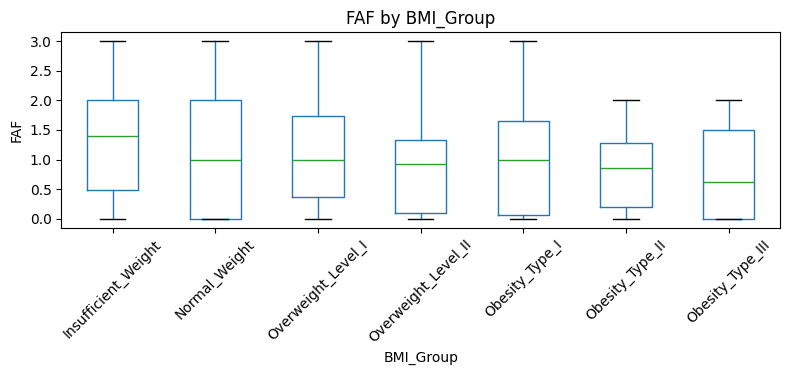


TUE by BMI_Group:


count   mean    std  median     q1     q3  min  max
BMI_Group                                                               
Insufficient_Weight    266  0.854  0.635   1.000  0.229  1.257  0.0  2.0
Normal_Weight          295  0.691  0.696   1.000  0.000  1.000  0.0  2.0
Overweight_Level_I     320  0.630  0.644   0.470  0.000  1.000  0.0  2.0
Overweight_Level_II    232  0.711  0.615   0.743  0.000  1.000  0.0  2.0
Obesity_Type_I         368  0.650  0.679   0.513  0.000  1.071  0.0  2.0
Obesity_Type_II        338  0.562  0.530   0.476  0.009  0.912  0.0  2.0
Obesity_Type_III       268  0.586  0.290   0.649  0.364  0.844  0.0  1.0

In [86]:

# ==============================================
# Numeric vs BMI — grouped stats + boxplots
# ==============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

# ---- Load data (dfc > df > CSV) ----
if "dfc" in globals():
    data = dfc.copy()
elif "df" in globals():
    data = df.copy()
else:
    data = pd.read_csv(Path(r"ObesityDataSet_raw_and_data_sinthetic.csv"))

# Tidy names / fix common typo
data.columns = [c.strip() for c in data.columns]
if "CH20" in data.columns and "CH2O" not in data.columns:
    data = data.rename(columns={"CH20": "CH2O"})

# Ensure numeric + BMI present
for c in ["Age","Height","Weight","NCP","CH2O","FAF","FCVC","TUE","BMI"]:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c], errors="coerce")
if {"Height","Weight"}.issubset(data.columns) and "BMI" not in data.columns:
    data["BMI"] = data["Weight"] / (data["Height"]**2)

# ---- BMI groups (WHO-style; overweight split at 27.5 to match dataset levels) ----
bmi_bins   = [-np.inf, 18.5, 25.0, 27.5, 30.0, 35.0, 40.0, np.inf]
bmi_labels = ["Insufficient_Weight","Normal_Weight","Overweight_Level_I","Overweight_Level_II",
              "Obesity_Type_I","Obesity_Type_II","Obesity_Type_III"]
data["BMI_Group"] = pd.cut(data["BMI"], bins=bmi_bins, labels=bmi_labels, right=False)

# ---- Numeric columns (exclude BMI itself) ----
num_cols = data.select_dtypes(include=["number"]).columns.tolist()
num_cols = [c for c in num_cols if c != "BMI"]

# (optional) if you already dropped Height/Weight this has no effect
EXCLUDE_HEIGHT_WEIGHT = False
if EXCLUDE_HEIGHT_WEIGHT:
    num_cols = [c for c in num_cols if c not in ["Height","Weight"]]

# ---- For each numeric feature: grouped stats + boxplot ----
SAVE_PNG = False

for col in num_cols:
    dfp = data[[col, "BMI_Group"]].dropna()
    if dfp.empty:
        continue

    # grouped stats
    tbl = (dfp.groupby("BMI_Group")[col]
              .agg(["count","mean","std","median",
                    ("q1", lambda s: s.quantile(.25)),
                    ("q3", lambda s: s.quantile(.75)),
                    "min","max"])
              .reindex(bmi_labels))
    print(f"\n{col} by BMI_Group:")
    display(tbl.round(3))

    # boxplot
    fig, ax = plt.subplots(figsize=(8,4))
    data.boxplot(column=col, by="BMI_Group",
                 positions=range(len(bmi_labels)),
                 labels=bmi_labels, grid=False, ax=ax, showfliers=True)
    ax.set_title(f"{col} by BMI_Group")
    ax.set_xlabel("BMI_Group"); ax.set_ylabel(col)
    plt.suptitle("")
    plt.xticks(rotation=45)
    plt.tight_layout()
    if SAVE_PNG:
        plt.savefig(f"box_{col}_by_BMI_Group.png", dpi=150, bbox_inches="tight")
    plt.show()


Data Modeling


LogReg CV f1_weighted: mean=0.8794 ± 0.0239
LogReg Test -> Acc=0.9043  Prec=0.9032  Rec=0.9043  F1=0.9031
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      1.00      0.95        53
      Normal_Weight       0.85      0.77      0.81        57
     Obesity_Type_I       0.94      0.91      0.93        70
    Obesity_Type_II       0.94      0.98      0.96        60
   Obesity_Type_III       0.98      0.98      0.98        65
 Overweight_Level_I       0.83      0.80      0.81        55
Overweight_Level_II       0.85      0.86      0.85        58

           accuracy                           0.90       418
          macro avg       0.90      0.90      0.90       418
       weighted avg       0.90      0.90      0.90       418




DecisionTree CV f1_weighted: mean=0.9576 ± 0.0109
DecisionTree Test -> Acc=0.9785  Prec=0.9793  Rec=0.9785  F1=0.9784
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00        53
      Normal_Weight       0.98      1.00      0.99        57
     Obesity_Type_I       0.99      0.97      0.98        70
    Obesity_Type_II       0.95      1.00      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       1.00      0.91      0.95        55
Overweight_Level_II       0.93      0.98      0.96        58

           accuracy                           0.98       418
          macro avg       0.98      0.98      0.98       418
       weighted avg       0.98      0.98      0.98       418



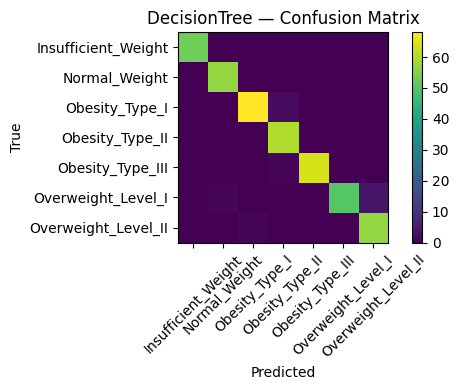


RandomForest CV f1_weighted: mean=0.9570 ± 0.0082
RandomForest Test -> Acc=0.9522  Prec=0.9531  Rec=0.9522  F1=0.9524
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.96      0.98        53
      Normal_Weight       0.87      0.93      0.90        57
     Obesity_Type_I       1.00      1.00      1.00        70
    Obesity_Type_II       0.98      1.00      0.99        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.87      0.87      0.87        55
Overweight_Level_II       0.93      0.90      0.91        58

           accuracy                           0.95       418
          macro avg       0.95      0.95      0.95       418
       weighted avg       0.95      0.95      0.95       418



In [80]:
# ========= Classification: predict NObeyesdad =========
import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 0) get a working dataframe
dfX = (df_anom_treated.copy() if "df_anom_treated" in globals()
       else dfc.copy() if "dfc" in globals()
       else df.copy())
dfX.columns = [c.strip() for c in dfX.columns]
if "CH20" in dfX.columns and "CH2O" not in dfX.columns:
    dfX = dfX.rename(columns={"CH20": "CH2O"})

# ensure BMI exists (used as a feature here)
if {"Height","Weight"}.issubset(dfX.columns) and "BMI" not in dfX.columns:
    dfX["BMI"] = pd.to_numeric(dfX["Weight"], errors="coerce") / (pd.to_numeric(dfX["Height"], errors="coerce")**2)

target = "NObeyesdad"
assert target in dfX.columns, "NObeyesdad not found."
y = dfX[target].astype("category")
X = dfX.drop(columns=[target])

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# column types
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# preprocess
numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler())])
categorical = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore"))])
pre = ColumnTransformer([("num", numeric, num_cols),
                         ("cat", categorical, cat_cols)])

# models
models = {
    "LogReg": Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=400, random_state=42))]),
    "DecisionTree": Pipeline([("pre", pre), ("clf", DecisionTreeClassifier(random_state=42))]),
    "RandomForest": Pipeline([("pre", pre), ("clf", RandomForestClassifier(n_estimators=300, random_state=42))]),
}

# CV + test evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def eval_model(name, pipe):
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_weighted", n_jobs=-1)
    print(f"{name} CV f1_weighted: mean={scores.mean():.4f} ± {scores.std():.4f}")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr, re, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", zero_division=0)
    print(f"{name} Test -> Acc={acc:.4f}  Prec={pr:.4f}  Rec={re:.4f}  F1={f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    # confusion matrix
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(labels)), labels, rotation=45); plt.yticks(range(len(labels)), labels)
    plt.colorbar(); plt.tight_layout(); plt.show()

for n, m in models.items():
    print("\n==============================")
    eval_model(n, m)



=== Logistic Regression ===
Test: Acc=0.9019  Prec=0.9014  Rec=0.9019  F1=0.9006
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      1.00      0.95        53
      Normal_Weight       0.85      0.79      0.82        57
     Obesity_Type_I       0.94      0.93      0.94        70
    Obesity_Type_II       0.92      1.00      0.96        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.79      0.82      0.80        55
Overweight_Level_II       0.87      0.78      0.82        58

           accuracy                           0.90       418
          macro avg       0.90      0.90      0.90       418
       weighted avg       0.90      0.90      0.90       418




=== Decision Tree ===
Test: Acc=0.9665  Prec=0.9665  Rec=0.9665  F1=0.9664
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99        53
      Normal_Weight       0.97      1.00      0.98        57
     Obesity_Type_I       0.97      0.97      0.97        70
    Obesity_Type_II       0.97      0.98      0.98        60
   Obesity_Type_III       0.98      0.98      0.98        65
 Overweight_Level_I       0.94      0.91      0.93        55
Overweight_Level_II       0.93      0.93      0.93        58

           accuracy                           0.97       418
          macro avg       0.97      0.97      0.97       418
       weighted avg       0.97      0.97      0.97       418



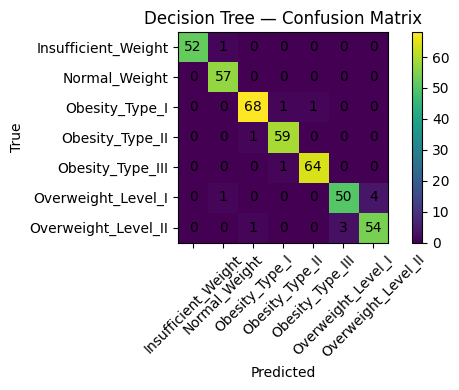

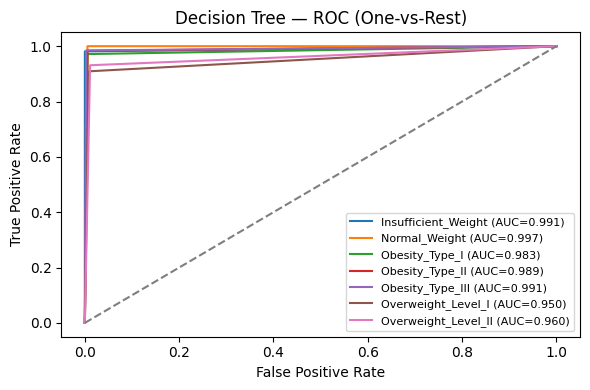

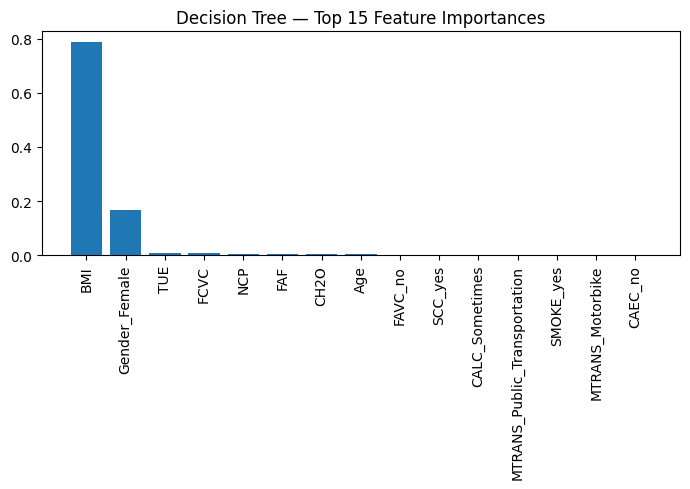


=== Random Forest ===
Test: Acc=0.9617  Prec=0.9643  Rec=0.9617  F1=0.9621
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.94      0.97        53
      Normal_Weight       0.85      0.98      0.91        57
     Obesity_Type_I       1.00      1.00      1.00        70
    Obesity_Type_II       0.98      1.00      0.99        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.94      0.89      0.92        55
Overweight_Level_II       0.96      0.91      0.94        58

           accuracy                           0.96       418
          macro avg       0.96      0.96      0.96       418
       weighted avg       0.96      0.96      0.96       418



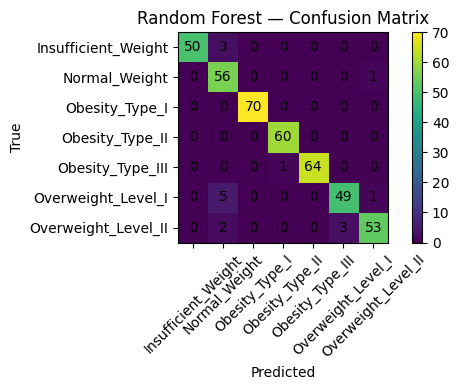

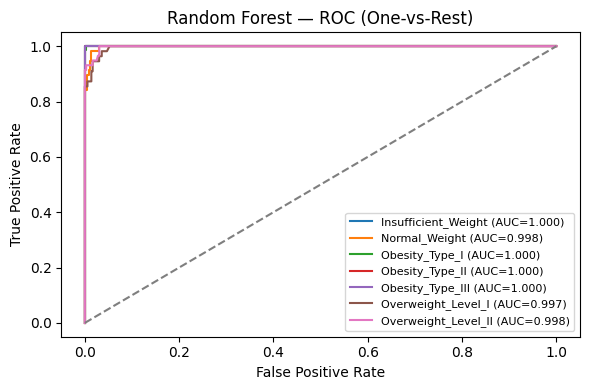

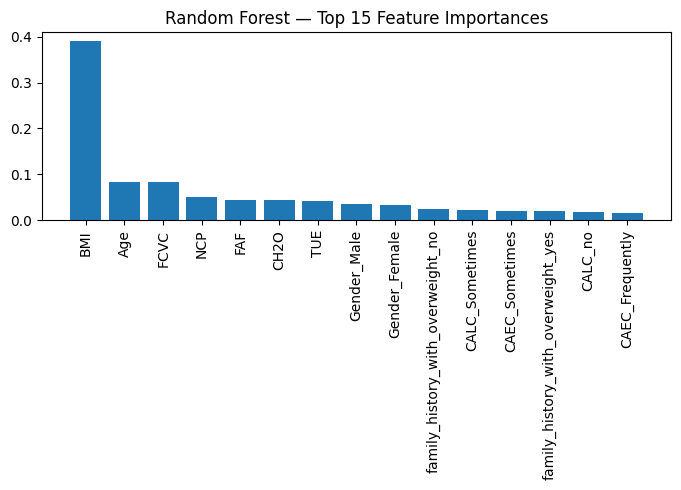

In [81]:
# ============================================
# Models & Graphs (NO anomaly treatment)
# Logistic Regression, Decision Tree, Random Forest
# ============================================
import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_recall_fscore_support, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# ---------- 0) Get data (no anomaly treatment) ----------
RAW_PATH = r"ObesityDataSet_raw_and_data_sinthetic.csv"  # change if not in the same folder

if "dfc" in globals():
    data = dfc.copy()
elif "df" in globals():
    data = df.copy()
else:
    data = pd.read_csv(RAW_PATH)

data.columns = [c.strip() for c in data.columns]
# Fix common typo CH20 -> CH2O
if "CH20" in data.columns and "CH2O" not in data.columns:
    data = data.rename(columns={"CH20": "CH2O"})

# Ensure BMI exists (useful predictor)
if {"Height","Weight"}.issubset(data.columns) and "BMI" not in data.columns:
    data["BMI"] = pd.to_numeric(data["Weight"], errors="coerce") / (pd.to_numeric(data["Height"], errors="coerce")**2)

target = "NObeyesdad"
assert target in data.columns, "NObeyesdad column not found."
y = data[target].astype("category")
X = data.drop(columns=[target])

# ---------- 1) Train / test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- 2) Preprocess ----------
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler())])
categorical = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore"))])

pre = ColumnTransformer([("num", numeric, num_cols),
                         ("cat", categorical, cat_cols)])

# ---------- 3) Models ----------
logreg = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=500, random_state=42))])
dtree  = Pipeline([("pre", pre), ("clf", DecisionTreeClassifier(random_state=42))])
rf     = Pipeline([("pre", pre), ("clf", RandomForestClassifier(n_estimators=300, random_state=42))])

models = {
    "Logistic Regression": logreg,
    "Decision Tree": dtree,
    "Random Forest": rf,
}

# ---------- 4) Plot helpers ----------
def plot_confusion(mname, model, Xt, yt):
    labels = np.unique(yt)
    cm = confusion_matrix(yt, model.predict(Xt), labels=labels)
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{mname} — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar()
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

def plot_multiclass_roc(mname, model, Xt, yt):
    if not hasattr(model, "predict_proba"):
        print(f"{mname}: predict_proba not available, skipping ROC.")
        return
    lb = LabelBinarizer()
    y_bin = lb.fit_transform(yt)                         # shape (n_samples, K)
    y_score = model.predict_proba(Xt)
    if isinstance(y_score, list):                        # robust for older sklearn
        y_score = np.column_stack(y_score)
    plt.figure(figsize=(6,4))
    for i in range(y_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{lb.classes_[i]} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(f"{mname} — ROC (One-vs-Rest)")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

def get_feature_names(preprocessor):
    feats = []
    if len(num_cols):
        feats.extend(num_cols)
    if len(cat_cols):
        ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        feats.extend(ohe.get_feature_names_out(cat_cols).tolist())
    return feats

def plot_tree_feature_importance(mname, model, topn=15):
    clf = model.named_steps["clf"]
    if not hasattr(clf, "feature_importances_"):
        print(f"{mname}: no feature_importances_, skipping.")
        return
    feats = get_feature_names(model.named_steps["pre"])
    importances = clf.feature_importances_
    idx = np.argsort(importances)[::-1][:topn]
    plt.figure(figsize=(7,5))
    plt.bar(range(len(idx)), importances[idx])
    plt.xticks(range(len(idx)), [feats[i] for i in idx], rotation=90)
    plt.title(f"{mname} — Top {topn} Feature Importances")
    plt.tight_layout()
    plt.show()

def plot_logreg_coefficients(model, topn=15):
    clf = model.named_steps["clf"]
    coefs = clf.coef_                              # shape (K, n_features)
    feats = get_feature_names(model.named_steps["pre"])
    abs_mean = np.mean(np.abs(coefs), axis=0)      # OVR-average |coef|
    idx = np.argsort(abs_mean)[::-1][:topn]
    plt.figure(figsize=(7,5))
    plt.bar(range(len(idx)), abs_mean[idx])
    plt.xticks(range(len(idx)), [feats[i] for i in idx], rotation=90)
    plt.title(f"Logistic Regression — Top {topn} |coef| (OVR-avg)")
    plt.tight_layout()
    plt.show()

def plot_small_tree_structure(model, max_depth=3):
    if not isinstance(model.named_steps["clf"], DecisionTreeClassifier):
        return
    Xtr = model.named_steps["pre"].transform(X_train)
    ytr = y_train.to_numpy()
    shallow = DecisionTreeClassifier(random_state=42, max_depth=max_depth)
    shallow.fit(Xtr, ytr)
    plt.figure(figsize=(12,6))
    plot_tree(shallow, max_depth=max_depth, filled=False, fontsize=6)
    plt.title(f"Decision Tree — structure (max_depth={max_depth})")
    plt.tight_layout()
    plt.show()

# ---------- 5) Train + graphs ----------
for name, pipe in models.items():
    print(f"\n=== {name} ===")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr, re, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", zero_division=0)
    print(f"Test: Acc={acc:.4f}  Prec={pr:.4f}  Rec={re:.4f}  F1={f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    # 1) Confusion matrix
    plot_confusion(name, pipe, X_test, y_test)

    # 2) ROC curves (multiclass OVR)
    plot_multiclass_roc(name, pipe, X_test, y_test)

    # 3) Feature importance / coefficients
    if name == "Logistic Regression":
        plot_logreg_coefficients(pipe, topn=15)
    else:
        plot_tree_feature_importance(name, pipe, topn=15)

# Optional: a small, readable tree structure preview
plot_small_tree_structure(models["Decision Tree"], max_depth=3)


Further Data Analysis

In [82]:
# ========= Regression: predict BMI =========
import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# 0) data
dfR = (df_anom_treated.copy() if "df_anom_treated" in globals()
       else dfc.copy() if "dfc" in globals()
       else df.copy())
dfR.columns = [c.strip() for c in dfR.columns]
if "CH20" in dfR.columns and "CH2O" not in dfR.columns:
    dfR = dfR.rename(columns={"CH20": "CH2O"})

# ensure BMI exists
if {"Height","Weight"}.issubset(dfR.columns) and "BMI" not in dfR.columns:
    dfR["BMI"] = pd.to_numeric(dfR["Weight"], errors="coerce") / (pd.to_numeric(dfR["Height"], errors="coerce")**2)

target = "BMI"
assert target in dfR.columns, "BMI not found."
y = pd.to_numeric(dfR[target], errors="coerce")

# drop leakage features & the class label (if present)
drop_cols = [c for c in ["BMI","Height","Weight","NObeyesdad"] if c in dfR.columns]
X = dfR.drop(columns=drop_cols)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# columns
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# preprocess (RobustScaler handles outliers better)
numeric = Pipeline([("imputer", SimpleImputer(strategy="median")),
                    ("scaler", RobustScaler())])
categorical = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore"))])
pre = ColumnTransformer([("num", numeric, num_cols),
                         ("cat", categorical, cat_cols)])

# models
reg_models = {
    "DecisionTreeReg": Pipeline([("pre", pre), ("reg", DecisionTreeRegressor(random_state=42))]),
    "RandomForestReg": Pipeline([("pre", pre), ("reg", RandomForestRegressor(n_estimators=300, random_state=42))]),
}

# CV + test evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def eval_reg(name, pipe):
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1)
    print(f"{name} CV MAE: mean={-scores.mean():.3f} ± {scores.std():.3f}")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Test -> MAE={mae:.3f}  RMSE={rmse:.3f}  R²={r2:.3f}")

    # feature importance (RF only)
    if hasattr(pipe.named_steps["reg"], "feature_importances_"):
        # get feature names after one-hot
        preprocessor = pipe.named_steps["pre"]
        ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        cat_feats = []
        if len(cat_cols):
            cat_feats = ohe.get_feature_names_out(cat_cols).tolist()
        feats = num_cols + cat_feats
        importances = pipe.named_steps["reg"].feature_importances_
        idx = np.argsort(importances)[::-1][:15]
        plt.figure(figsize=(6,4))
        plt.barh([feats[i] for i in idx][::-1], importances[idx][::-1])
        plt.title(f"{name} — Top 15 feature importances")
        plt.tight_layout(); plt.show()

for n, m in reg_models.items():
    print("\n==============================")
    eval_reg(n, m)



DecisionTreeReg CV MAE: mean=2.427 ± 0.167


TypeError: got an unexpected keyword argument 'squared'